**<h2>Computing Generalisation error** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

import time

**<h3>Training and Test Set**

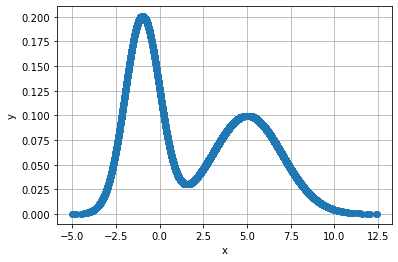

In [2]:
mu, sigma = 0, 1 # mean and standard deviation of normal distribution

# # Double well potential
# Eo = 2*10**(-4) #Hartree
# c  = 0.045

#x  = np.linspace(-4, 4, num=1500) #np.random.uniform(-6,6,1000) #np.random.normal(mu, sigma, 2500) #np.random.exponential(0.63,size=2500)
# x  = np.reshape(x,(len(x),1))

# V  = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x-mu)**2/(2*sigma**2))   #Eo * (c * x**4 - x**2) 
# V  = np.reshape(V,(len(V),1))

N=10000
mu1, sigma1 = 5, 2
mu2, sigma2 = -1, 1
x1 = np.random.normal(mu1, sigma1, N)
x2 = np.random.normal(mu2, sigma2, N)
x = np.concatenate([x1, x2])
x  = np.reshape(x,(len(x),1))


V = 0.5*(1/np.sqrt(2*np.pi*sigma1**2))*np.exp(-(x-mu1)**2/(2*sigma1**2)) + 0.5*(1/np.sqrt(2*np.pi*sigma2**2))*np.exp(-(x-mu2)**2/(2*sigma2**2))
V  = np.reshape(V,(len(V),1))

# shuffler = np.random.permutation(len(V))

# x = x[shuffler]

# V = V[shuffler]

test_set = torch.FloatTensor(x)
test_labels = torch.FloatTensor(V)


plt.plot(x,V,'o')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

In [3]:
# data_size            = np.shape(V)[0]       
# training_set_size    = data_size - 500

# # # Computing variance and mean on the training data only!
# # x_train = x[:training_set_size]
# # var  = np.std(x_train)
# # mean = np.mean(x_train)

# # normalize all data (training and test), using training set mean and variance
# data_set = x#(x-mean)/var 


# data_set = torch.FloatTensor(data_set)          


# # V_train  = V[:training_set_size]
# # var_lab  = np.std(V_train)
# # mean_lab = np.mean(V_train)

# labels   = V #(V-mean_lab)/var_lab
# labels = torch.FloatTensor(V)        



# # Splitting the adataset into training and test set
# training_set         = data_set[:training_set_size]
# test_set             = data_set[training_set_size:]

# train_labels         = labels[:training_set_size]
# test_labels          = labels[training_set_size:]

# # Dataset
# dataset = TensorDataset(training_set, train_labels)
# #print(dataset[0])

# # Creating the batches
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=training_set_size//8,
#                                            shuffle=True, num_workers=2, drop_last=False)



In [4]:
def generate_data():
    
    N=500
    mu1, sigma1 = 5, 2
    mu2, sigma2 = -1, 1
    x1 = np.random.normal(mu1, sigma1, N)
    x2 = np.random.normal(mu2, sigma2, N)
    x = np.concatenate([x1, x2])
    x  = np.reshape(x,(len(x),1))
    V = 0.5*(1/np.sqrt(2*np.pi*sigma1**2))*np.exp(-(x-mu1)**2/(2*sigma1**2)) + 0.5*(1/np.sqrt(2*np.pi*sigma2**2))*np.exp(-(x-mu2)**2/(2*sigma2**2))
    V  = np.reshape(V,(len(V),1))
    
    data_size            = np.shape(V)[0]       
    data_set = x

    data_set = torch.FloatTensor(data_set)          

    labels   = V 
    labels = torch.FloatTensor(V)        

    training_set         = data_set
    train_labels         = labels

    # Dataset
    dataset = TensorDataset(training_set, train_labels)

    # Creating the batches
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=data_size//10,
                                               shuffle=True, num_workers=2, drop_last=False)
    return data_set, labels,dataloader

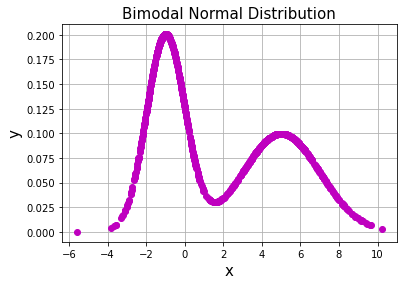

In [5]:
data       = generate_data()
data_set   = data[0]
labels     = data[1]
dataloader = data[2]

plt.plot(data_set,labels,'om')
plt.grid()
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)
plt.title('Bimodal Normal Distribution',fontsize=15)
plt.savefig('Bimodal_Norma_Distribution')

**<h3> Building Neural Network Architecture**

In [225]:
class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.fc1 = nn.Linear(1, 30)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc_out = nn.Linear(30, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x,train = True):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
#        x = torch.tanh(self.fc3(x))
        x = torch.sigmoid(self.fc_out(x))
#         x = torch.reshape(x,[1])
        return x


**<h3>Training the Neural Network**

In [226]:
def training(dataloader):
    torch.use_deterministic_algorithms(True)
    seed = 3
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    net = BPNN()
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    #optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.01)
    
    nepochs = 800
    losss = np.zeros(nepochs)
    for epoch in range(nepochs):  # loop over the dataset multiple times

        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            losss[epoch] = loss
#            print('[%d, %5d] loss: %.15f' %
#                      (epoch + 1, i + 1, loss))

    print('Finished Training')
    return losss, nepochs, net

**<h3>Plotting loss and prediction vs actual label**

In [227]:
def plot_loss(nepochs, losss,i):
    plt.plot(list(range(nepochs)),losss)
    plt.yscale('log')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Average training loss per epoch')
    plt.show()
#    plt.savefig('loss_{0}'.format(i))
#    return

In [228]:
def plot_prediction(test_set,test_labels,net,i):
    prediction = np.zeros(np.shape(test_labels)[0])
    for j in range(np.shape(test_set)[0]):
        prediction[j] = net(test_set[j])#[0]
    prediction = np.reshape(prediction,(len(prediction),1))
    
    plt.plot(test_set,test_labels, 'om',label = '$\pi(x)$')
    plt.plot(test_set,prediction, 'o', color='blue', label = '$\hat{\pi}(x)$')
    plt.grid()
#    plt.ticklabel_format(axis="y", style="plain")
    plt.title('Test set predictions vs actual labels')
    plt.legend()
    plt.show()
#    plt.savefig('pred_vs_lab{0}'.format(i))
    return prediction

**<h3>Computing Kullback Leibler Divergence**

In [229]:
# def kl_divergence(p, q):
#     kl_div = 0
#     for i in range(len(p)):
#         if p[i] != 0:
#             kl_div = kl_div + p[i] * np.log(p[i]/q[i])  # this would have been correct if we were
                                                          # multiplying by dx and used linspace for the points
#         else:
#             print('zero')
#     return kl_div

In [230]:
def kl_divergence(p, q):       # monte carlo (the test set has been sampled from the binomial distribution)
    kl_div = 0
    for i in range(len(p)):
        if p[i] != 0:
            kl_div = kl_div + np.log(p[i]/q[i]) 
        else:
            print('zero')
    return kl_div/len(p)

In [231]:
def mean_sq_error(p, q):
    mse = 0
    for i in range(len(p)):
        mse = mse + (p[i]-q[i])**2
    mse = mse/len(p)
    return mse

**<h3>Computing Normalisation Constant**

In [232]:
def normalisation_const(net):
    Z  = 0
    num_points = 20000
    minimum    = -5
    maximum    = 12.5
    x  = np.linspace(minimum, maximum, num=num_points)
    x  = np.reshape(x,(len(x),1))
    x = torch.FloatTensor(x)
    
    dx = (12.5 + 5)/(num_points-1)
    for i in range(num_points-1):
        Z  = Z + net(x[i])*dx
    return float(Z)

**<h3>Main loop - Computing generalisation error**

Finished Training
110.7407853603363


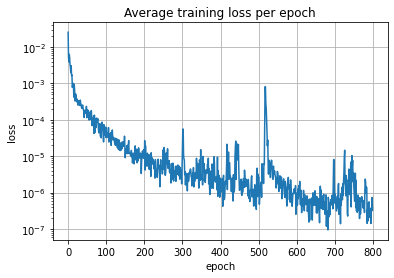

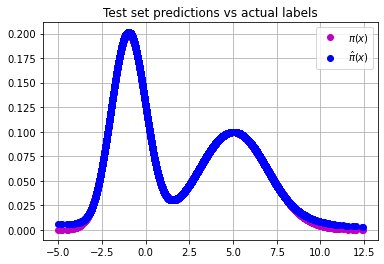

0 0.010296500905634354
0 5.950985540272752e-06
Finished Training
102.74207878112793


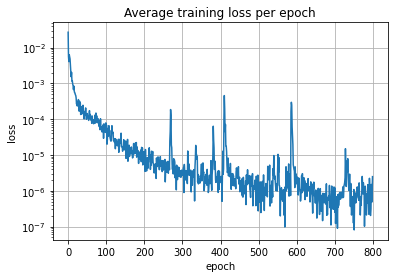

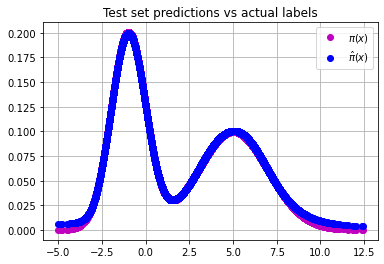

1 0.012587426489849165
1 1.2925943971969845e-05
Finished Training
106.51014018058777


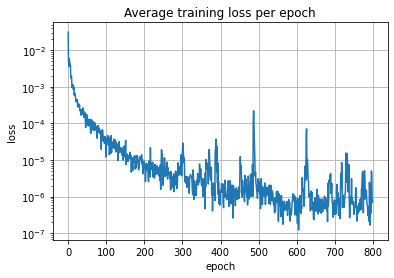

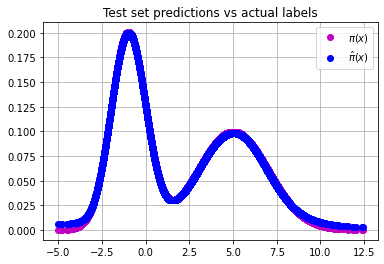

2 0.009940182977565956
2 4.518632007154562e-06
Finished Training
176.34648370742798


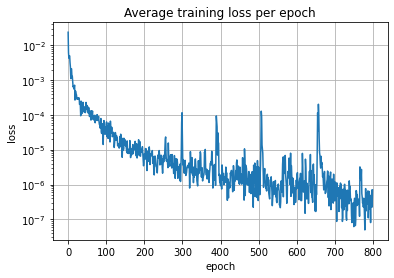

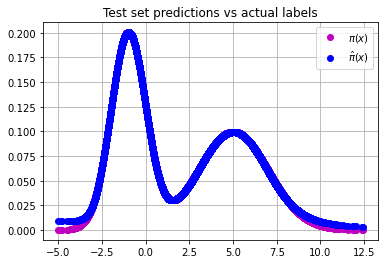

3 0.013835044250986885
3 8.943387020165936e-06
Finished Training
104.73403525352478


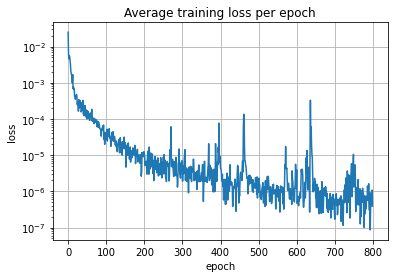

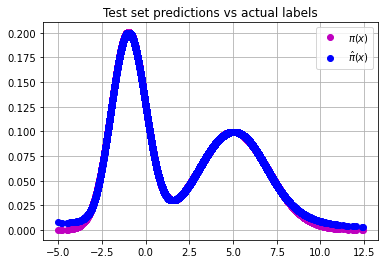

4 0.012573940814445624
4 9.19529167197237e-06
Finished Training
104.27740335464478


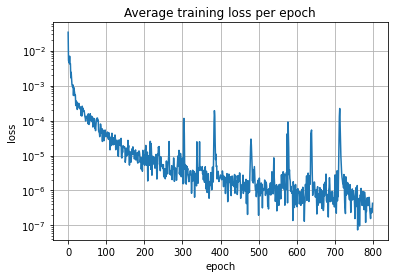

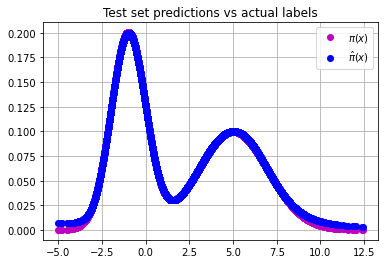

5 0.011943331639119016
5 1.0186694118406833e-05
Finished Training
103.3363618850708


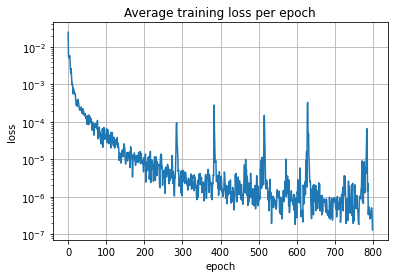

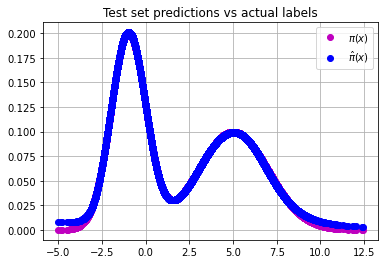

6 0.012631015667940344
6 7.383389207772896e-06
Finished Training
179.68205428123474


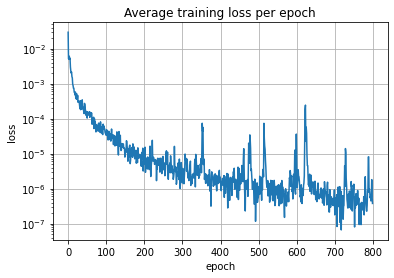

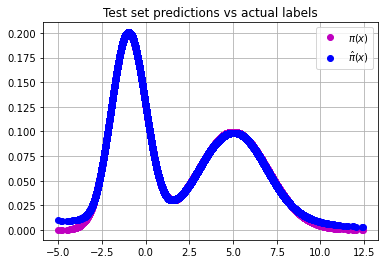

7 0.014216013118127901
7 8.333835711923488e-06
Finished Training
102.76304650306702


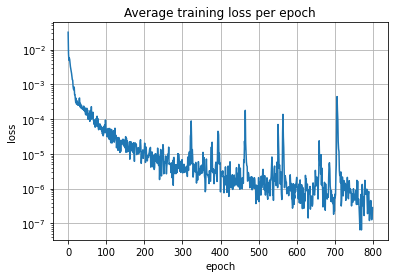

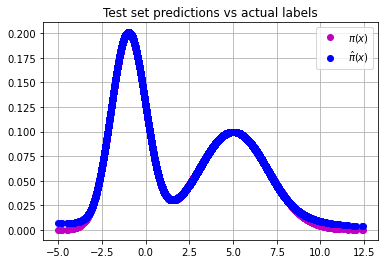

8 0.012636864780615124
8 8.14133965843076e-06
Finished Training
102.85554695129395


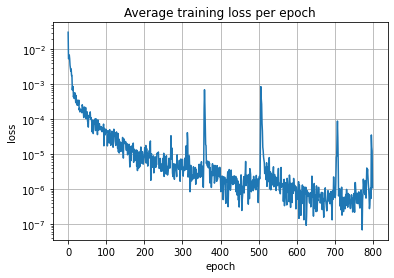

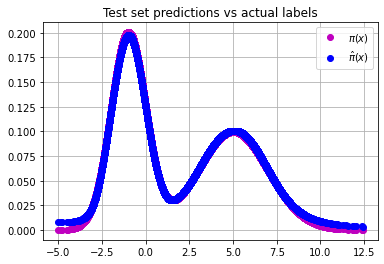

9 0.014069927356772158
9 1.8525795089524116e-05
Finished Training
104.03116202354431


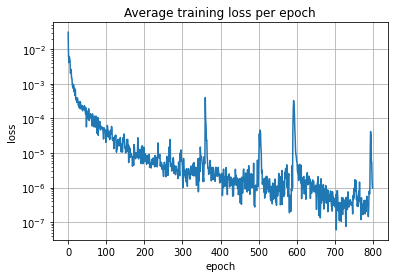

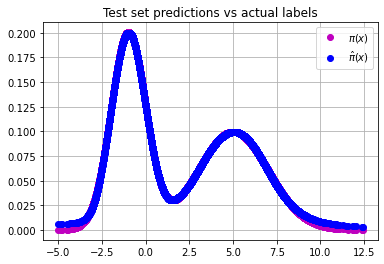

10 0.011320358593053335
10 7.152456546946186e-06
Finished Training
163.81909775733948


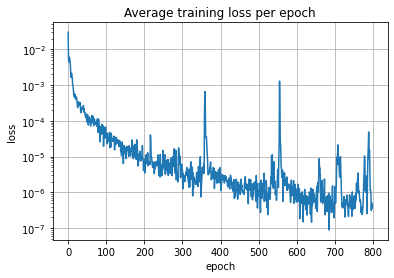

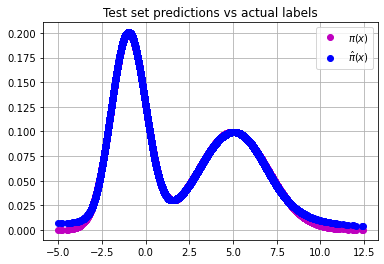

11 0.014588675788388827
11 9.661947471237227e-06
Finished Training
104.21049547195435


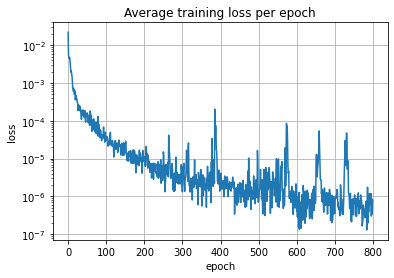

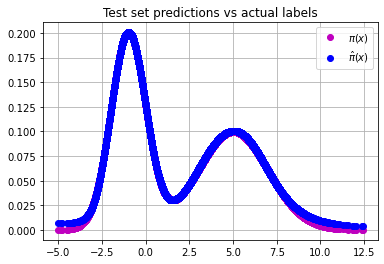

12 0.01347744467459741
12 1.2495363374748158e-05
Finished Training
102.9308819770813


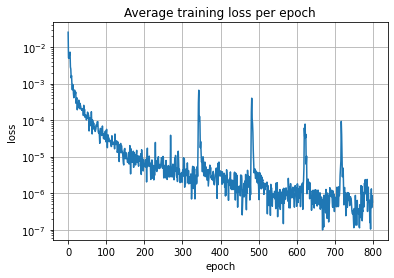

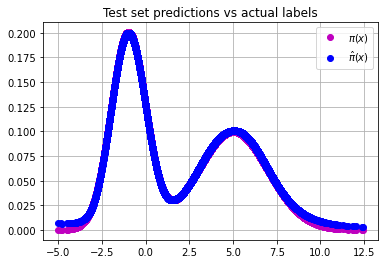

13 0.01149838247521076
13 1.2208633879367199e-05
Finished Training
105.5751256942749


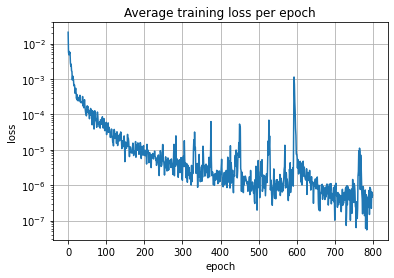

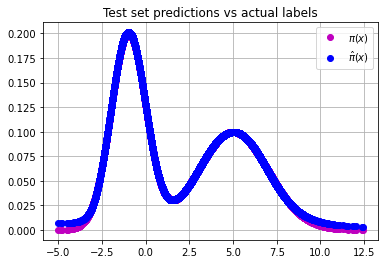

14 0.011544037023843655
14 6.761497982362498e-06
Finished Training
162.83026719093323


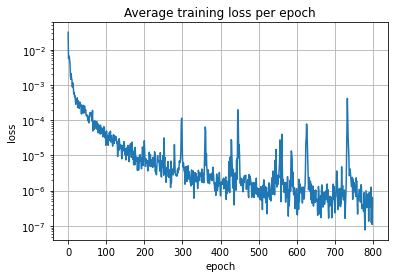

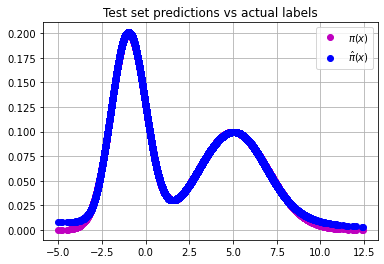

15 0.012898772237733645
15 7.715459442597363e-06
Finished Training
104.18836236000061


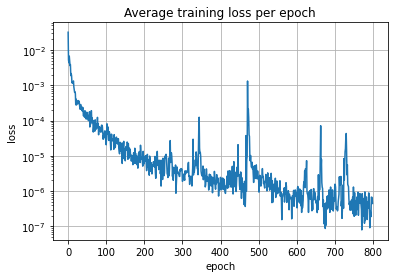

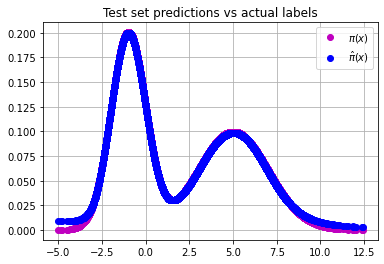

16 0.013382878222160067
16 7.754645719514919e-06
Finished Training
104.25075769424438


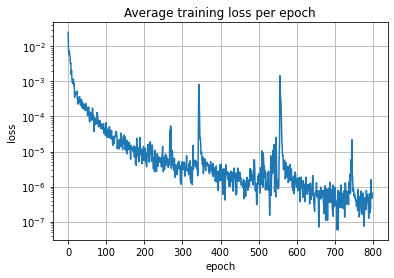

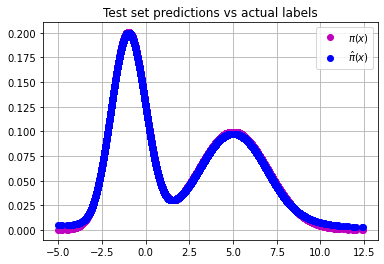

17 0.008159661600383896
17 2.9245501316100238e-06
Finished Training
103.54038548469543


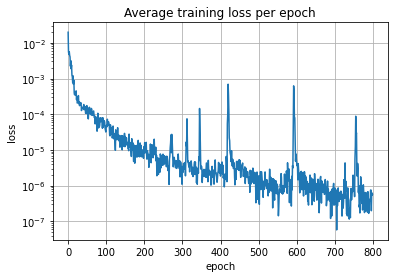

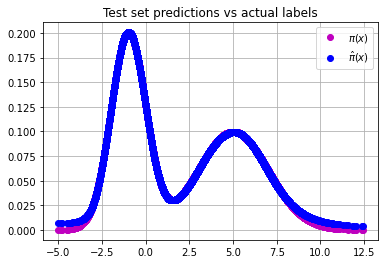

18 0.013439683386481004
18 9.119690436696477e-06
Finished Training
164.88223838806152


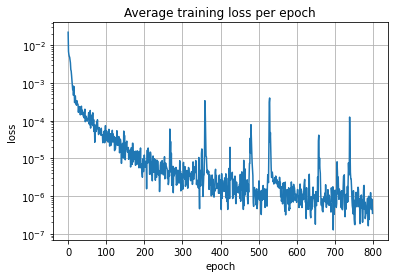

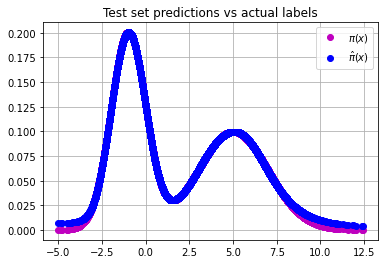

19 0.01480099385857832
19 1.2734753049788555e-05
Finished Training
104.94458889961243


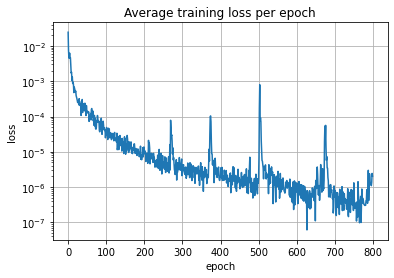

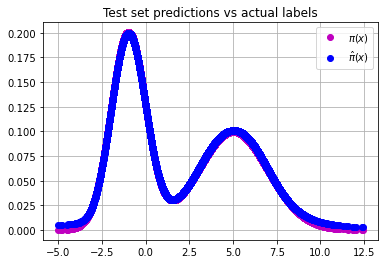

20 0.00919680688849528
20 1.0326848737262631e-05
Finished Training
103.18524122238159


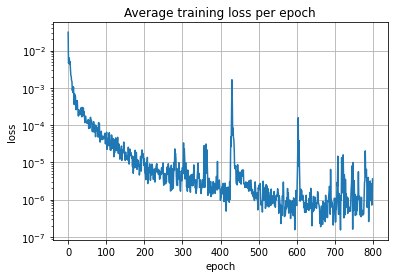

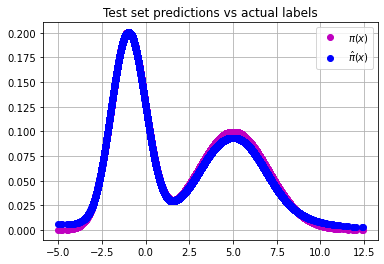

21 0.010662122814185632
21 8.57610666969544e-06
Finished Training
103.8534209728241


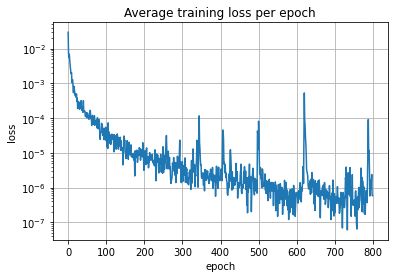

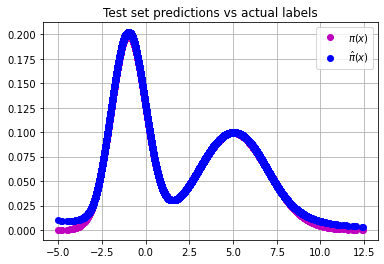

22 0.015022494689868477
22 1.0067621631390621e-05
Finished Training
163.87427306175232


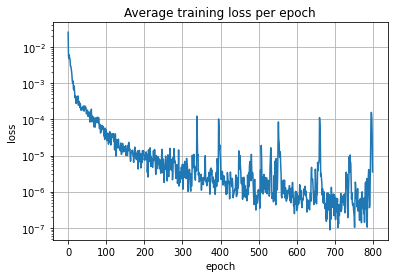

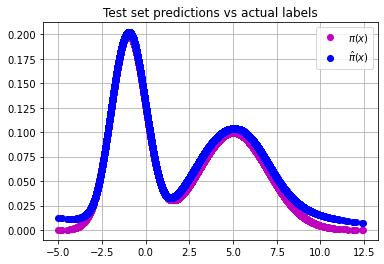

23 0.03062015798113464
23 9.542932195432493e-05
Finished Training
102.5839455127716


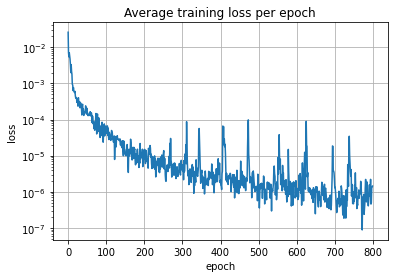

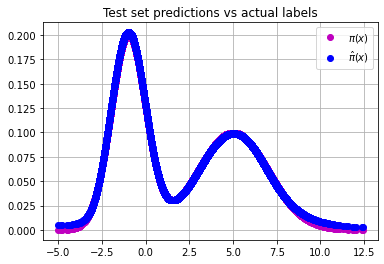

24 0.009593621970527367
24 4.431298568940153e-06
Finished Training
103.40450143814087


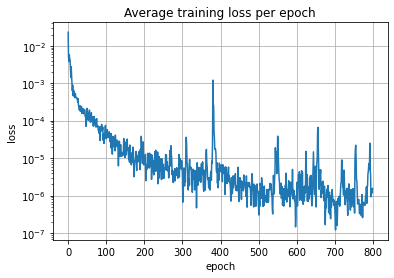

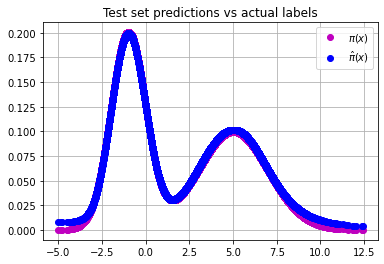

25 0.015650545551588707
25 2.352190499564875e-05
Finished Training
103.63259744644165


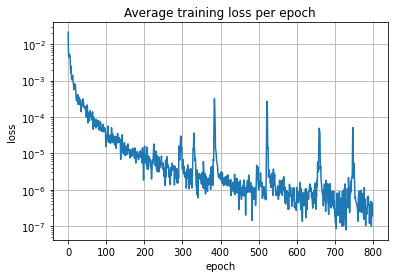

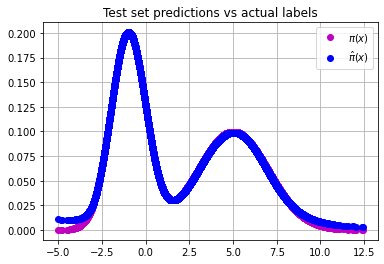

26 0.015306915848102447
26 9.299789033734851e-06
Finished Training
2972.142796278


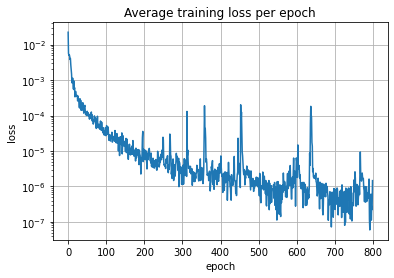

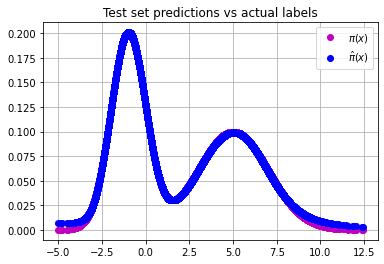

27 0.012410280329049618
27 7.757608652458958e-06
Finished Training
112.85004615783691


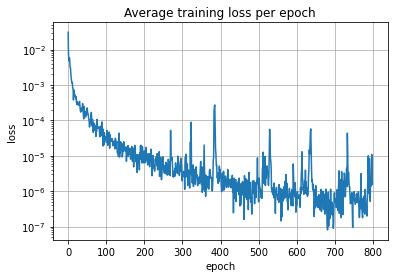

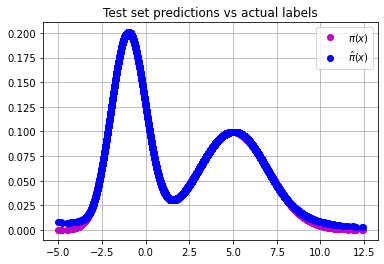

28 0.011972721626422793
28 7.954023006382337e-06
Finished Training
113.33382391929626


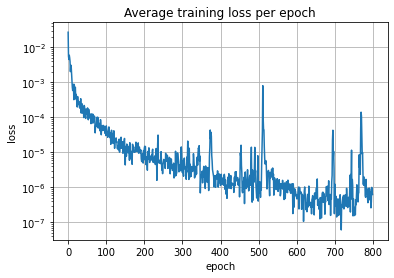

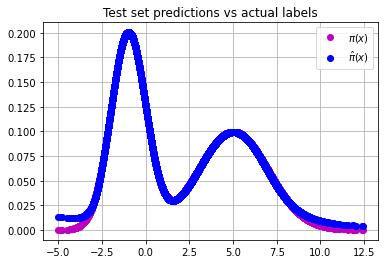

29 0.019627822626682764
29 1.452851693300494e-05
Finished Training
112.90792179107666


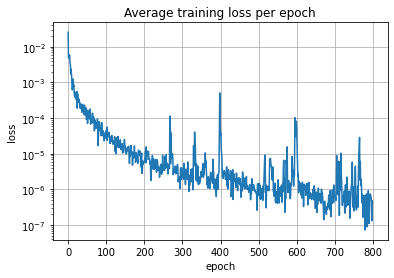

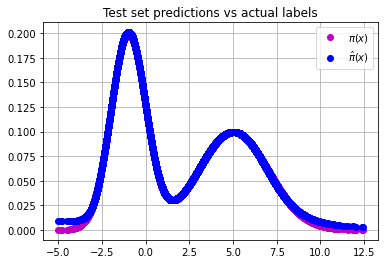

30 0.013249635851703556
30 8.1025820133958e-06
Finished Training
164.08523058891296


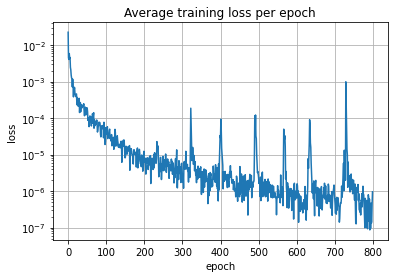

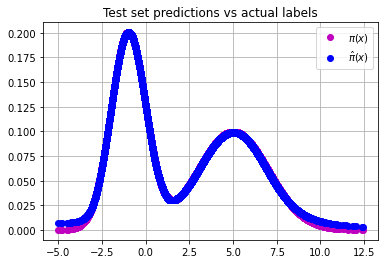

31 0.012868111704383315
31 7.491077101390404e-06
Finished Training
109.93568921089172


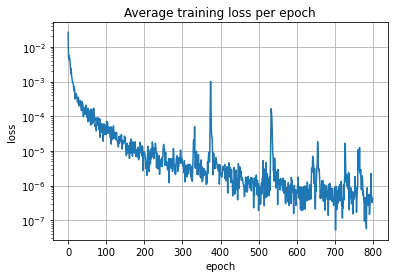

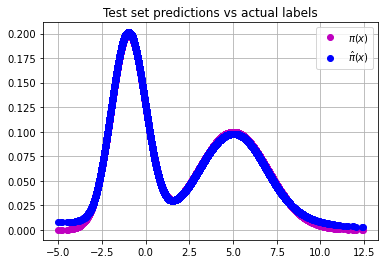

32 0.012853442818238935
32 6.055274312165913e-06
Finished Training
112.50980687141418


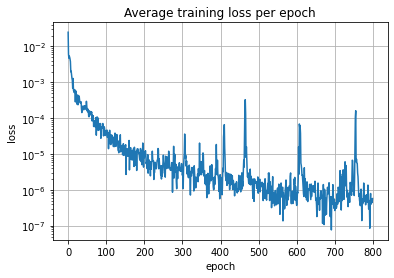

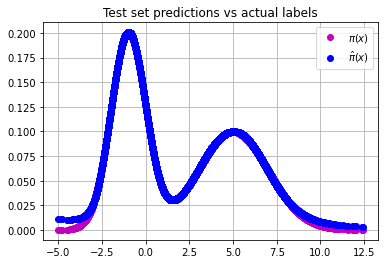

33 0.016040493871914252
33 1.2582503724565724e-05
Finished Training
111.8529224395752


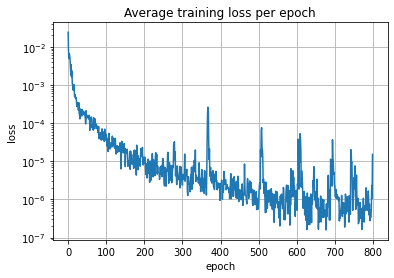

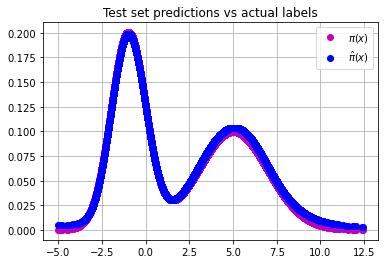

34 0.010832040841230038
34 2.9259492221987266e-05
Finished Training
164.26935958862305


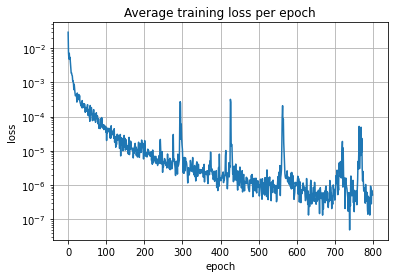

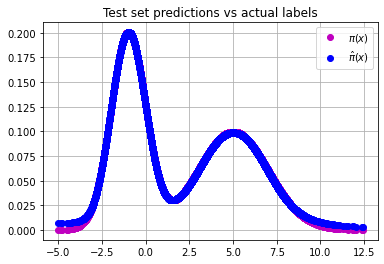

35 0.011618239857503378
35 5.7969173278981075e-06
Finished Training
111.75314259529114


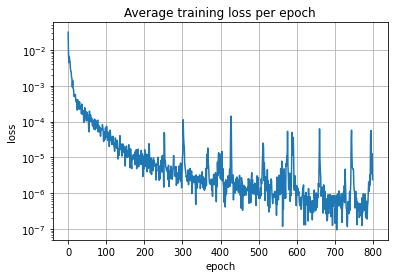

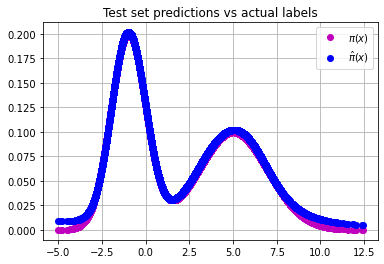

36 0.019134606645889344
36 2.5466756129610564e-05
Finished Training
113.12000322341919


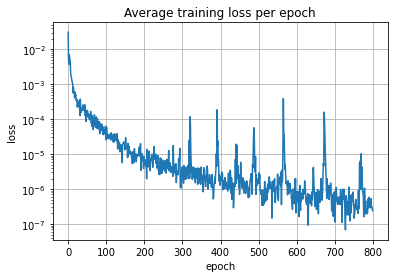

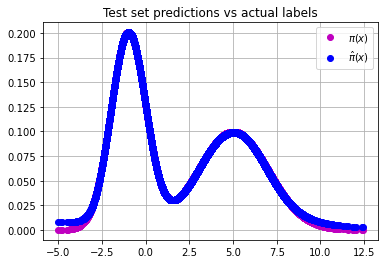

37 0.011768506546508328
37 6.524582287935705e-06
Finished Training
112.54086875915527


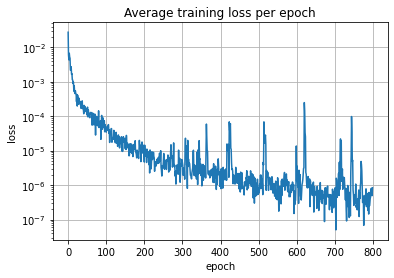

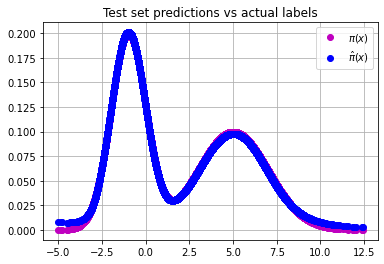

38 0.011694509346188688
38 4.756319126611097e-06
Finished Training
163.84173202514648


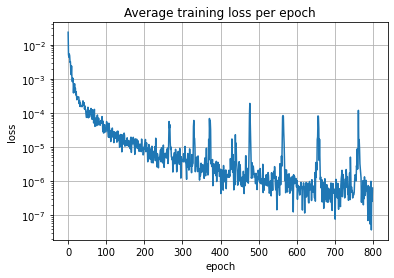

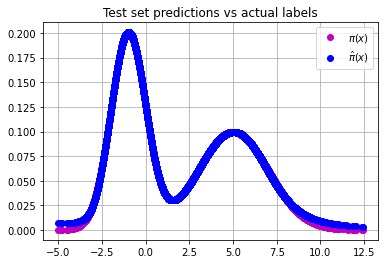

39 0.012712842746593594
39 8.407691182944285e-06
Finished Training
113.71713328361511


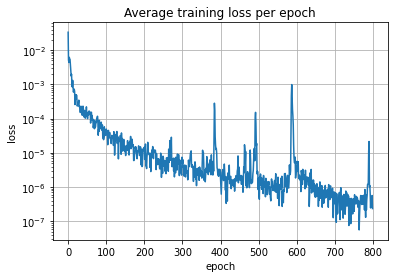

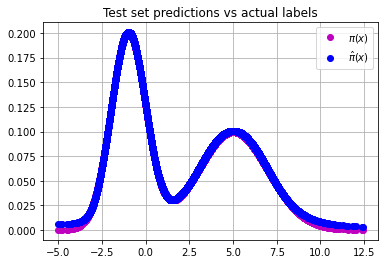

40 0.01074513324432534
40 8.55228657224734e-06
Finished Training
113.01219844818115


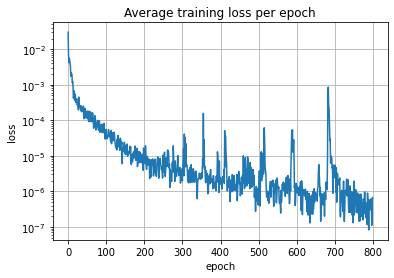

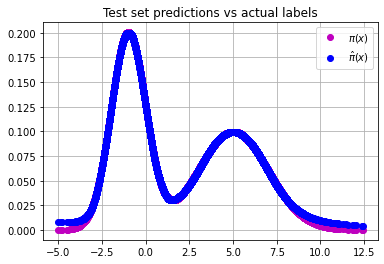

41 0.01563102374151113
41 1.1914641993519467e-05
Finished Training
114.31452560424805


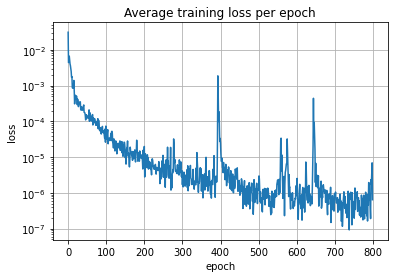

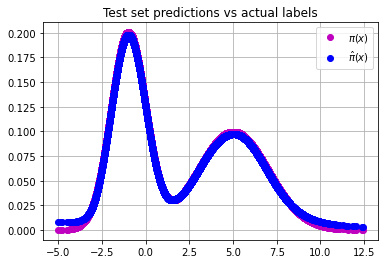

42 0.012773520905783431
42 7.808277690702588e-06
Finished Training
163.4672977924347


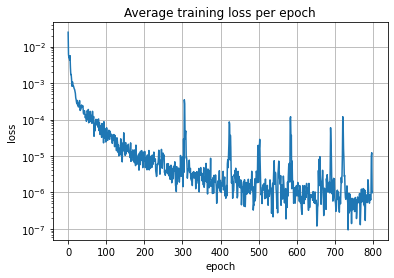

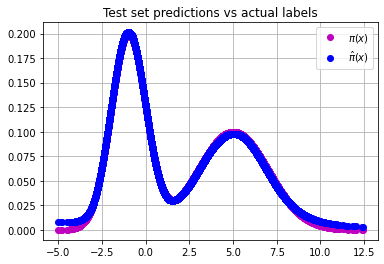

43 0.01324500386779498
43 6.537480637290303e-06
Finished Training
111.59260320663452


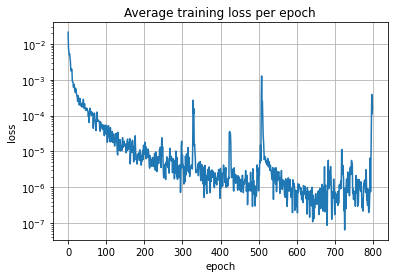

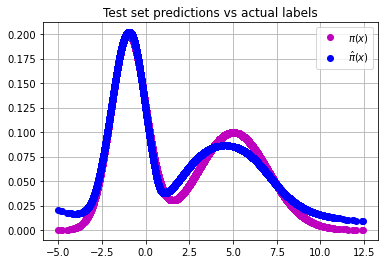

44 0.04977984239139874
44 0.00014344507282538447
Finished Training
111.83303594589233


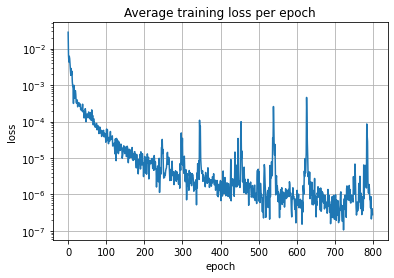

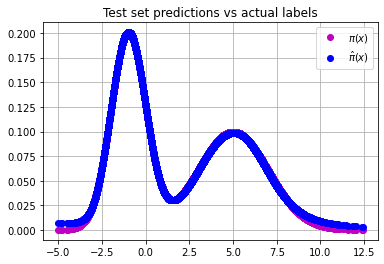

45 0.012196498598557717
45 6.796771524731082e-06
Finished Training
111.28773379325867


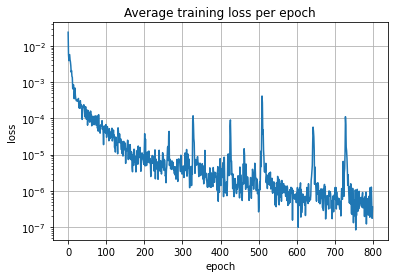

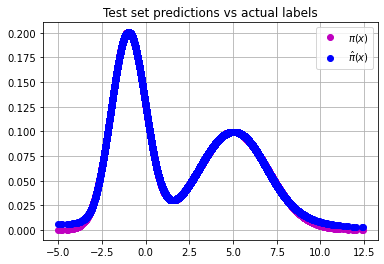

46 0.00978712469002581
46 5.9059815429761115e-06
Finished Training
162.87479543685913


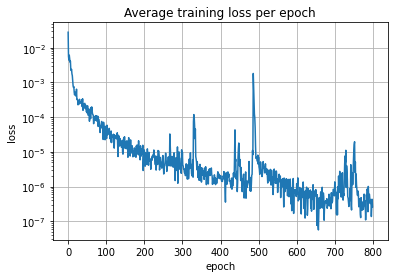

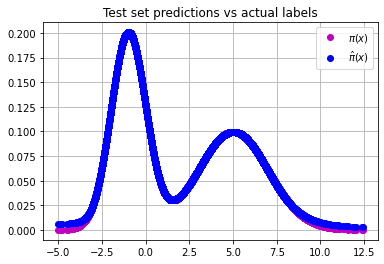

47 0.009764396566811988
47 5.2763502275495245e-06
Finished Training
112.43423247337341


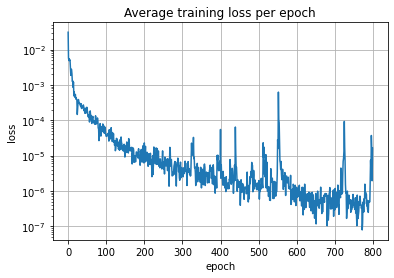

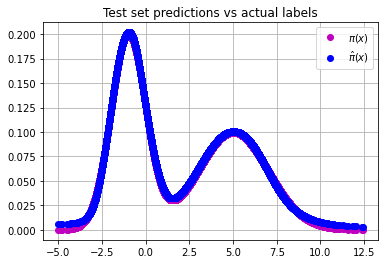

48 0.01080200104449452
48 7.617185853315013e-06
Finished Training
111.34678244590759


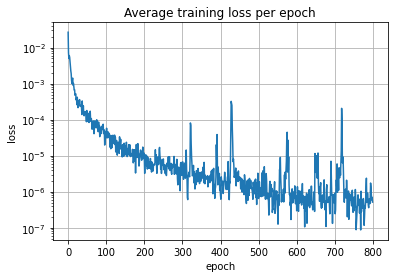

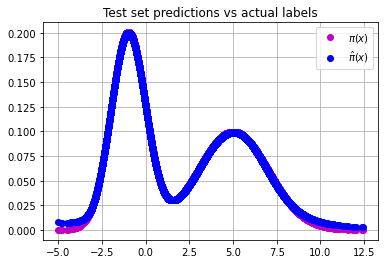

49 0.011723079146046058
49 6.950392965130593e-06
Finished Training
112.8742082118988


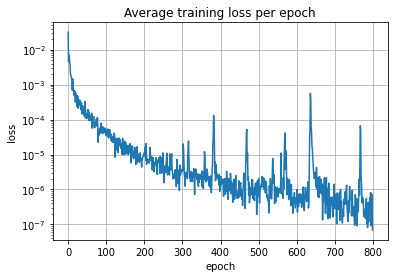

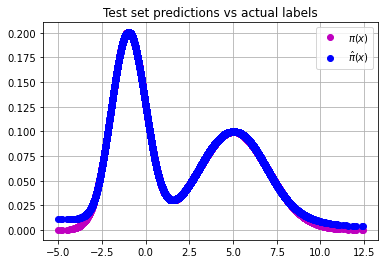

50 0.01696134525461956
50 1.3854755908937513e-05
Finished Training
164.9691014289856


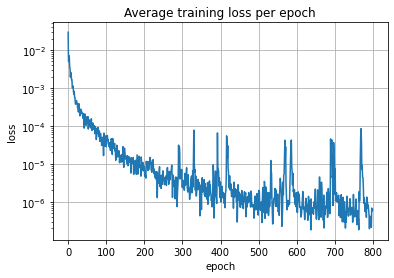

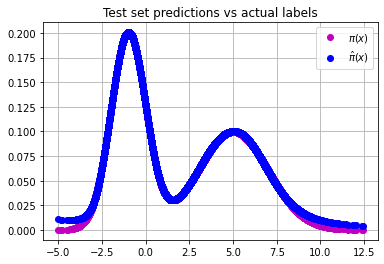

51 0.01846982926493919
51 1.7024515801087356e-05
Finished Training
112.75235295295715


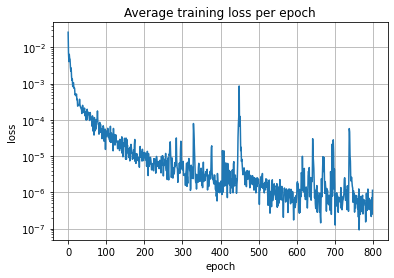

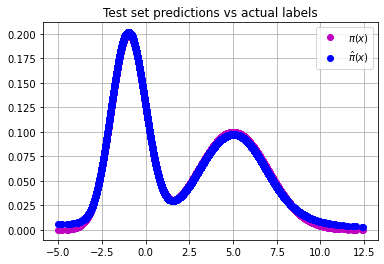

52 0.011107118451340471
52 4.75689449939927e-06
Finished Training
111.73377776145935


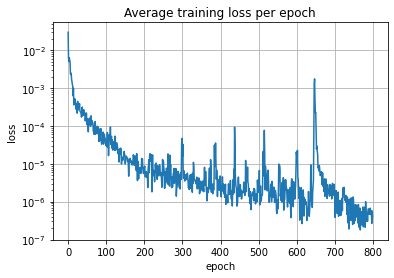

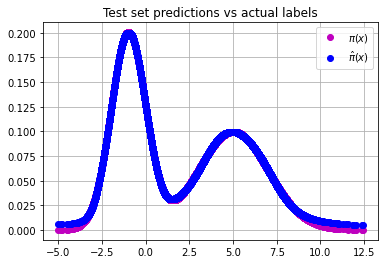

53 0.01362272036755648
53 8.667601696559361e-06
Finished Training
112.58657360076904


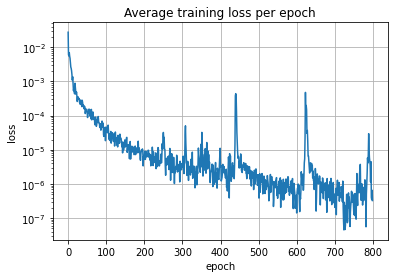

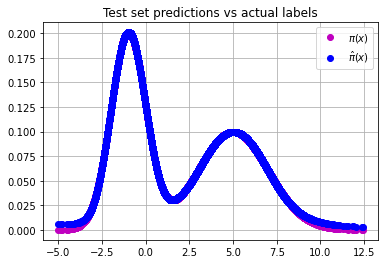

54 0.009797430409453628
54 5.402190510039807e-06
Finished Training
163.44250345230103


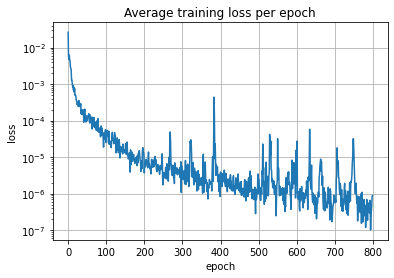

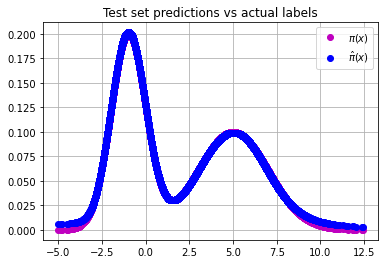

55 0.011206522784680081
55 6.097506339828299e-06
Finished Training
112.59004044532776


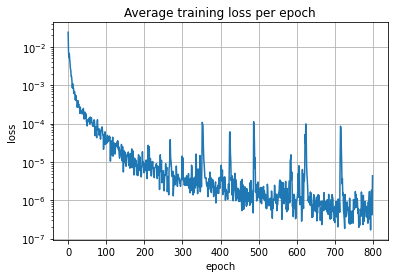

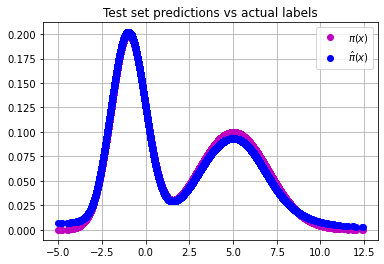

56 0.01320164918981514
56 1.2957452502125095e-05
Finished Training
113.44744777679443


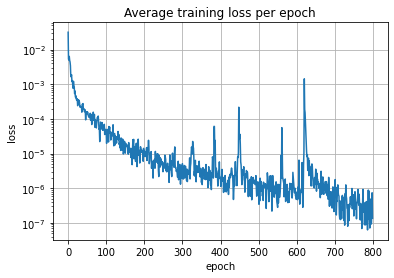

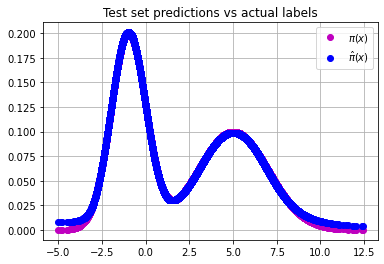

57 0.014045051267628639
57 8.189276081505351e-06
Finished Training
112.20446109771729


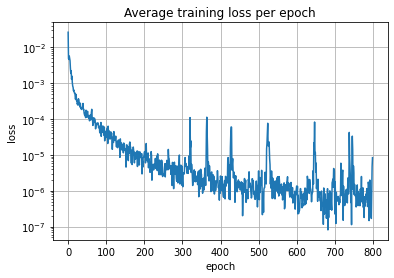

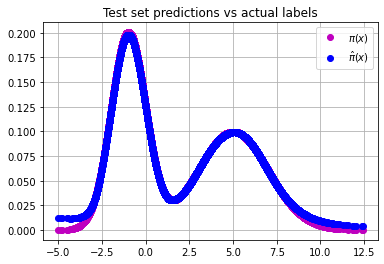

58 0.018951203710279002
58 2.0375005421628086e-05
Finished Training
162.62571454048157


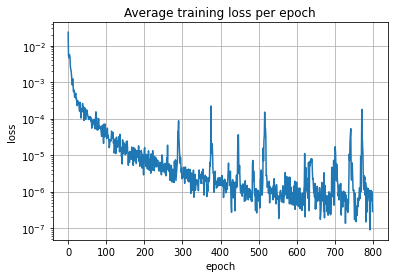

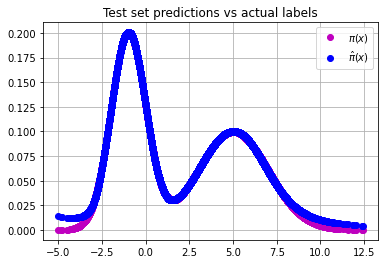

59 0.02193113888056623
59 2.1372007791477978e-05
Finished Training
113.27551579475403


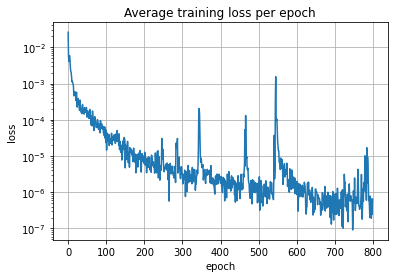

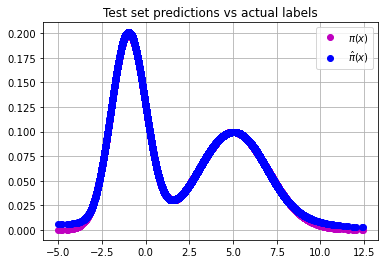

60 0.009963894671828098
60 5.322325397970288e-06
Finished Training
112.15573859214783


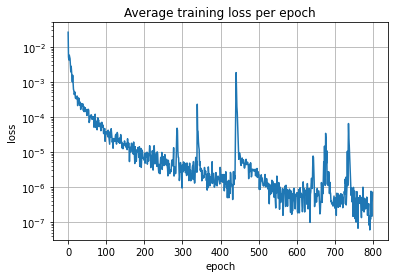

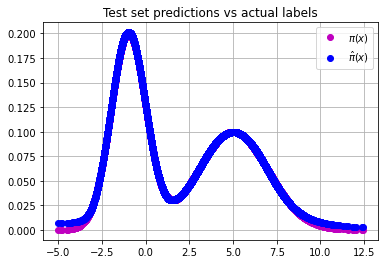

61 0.011183664223202529
61 6.0475254116841876e-06
Finished Training
112.70632791519165


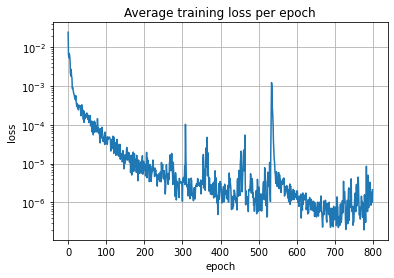

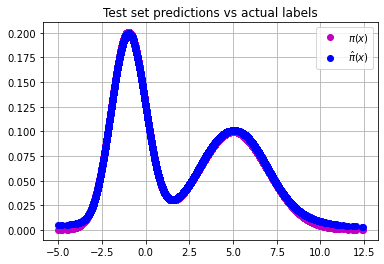

62 0.010334397885310688
62 1.3029047507868013e-05
Finished Training
163.59890604019165


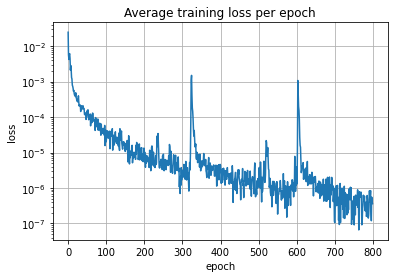

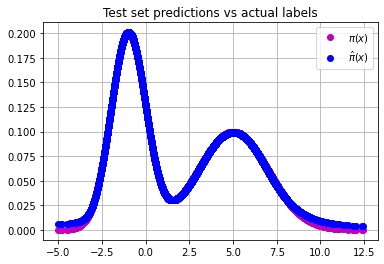

63 0.012451901962486465
63 7.816845263601011e-06
Finished Training
114.37738943099976


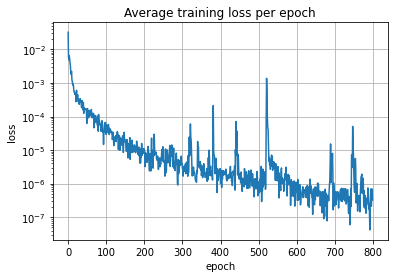

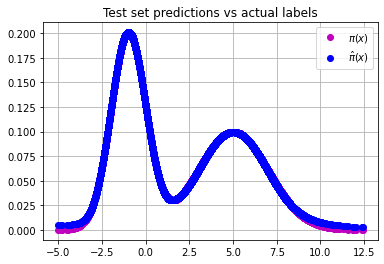

64 0.008589237942269509
64 3.885207663869529e-06
Finished Training
112.26772546768188


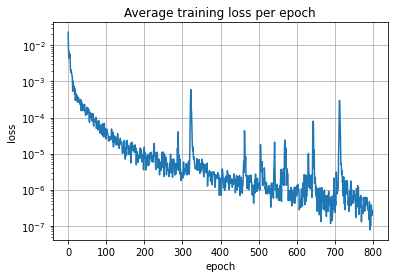

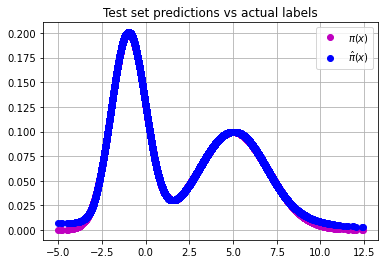

65 0.01131075323992991
65 7.233249925340182e-06
Finished Training
111.98647141456604


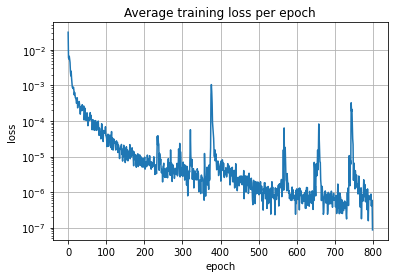

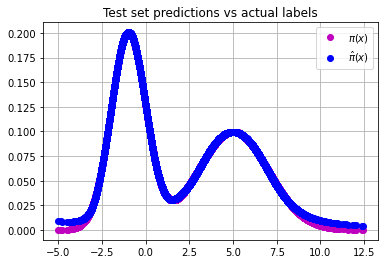

66 0.016057182578423552
66 1.225506448387733e-05
Finished Training
164.50832748413086


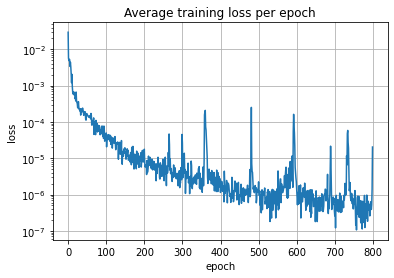

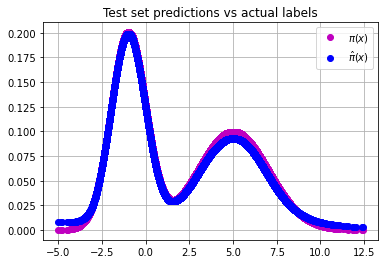

67 0.012733842808920844
67 8.657556374373234e-06
Finished Training
112.25722599029541


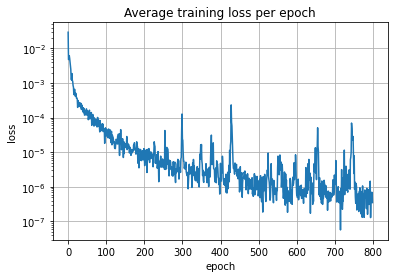

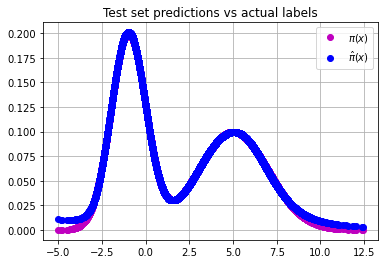

68 0.016266594127200388
68 1.1854984506547507e-05
Finished Training
111.80365490913391


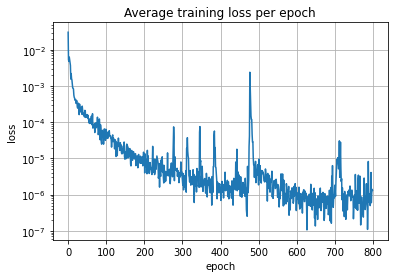

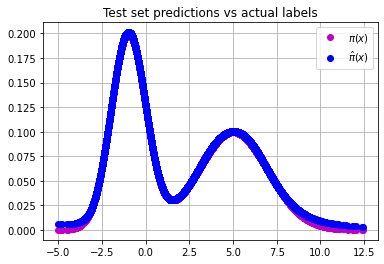

69 0.01141795845680174
69 9.30238103209488e-06
Finished Training
112.62282156944275


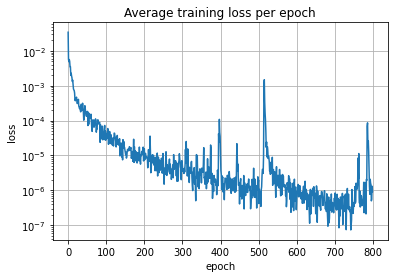

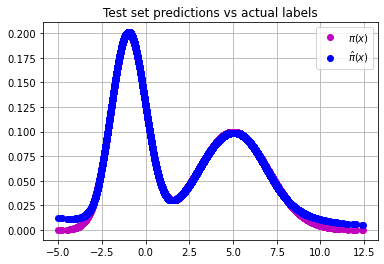

70 0.02219325532943343
70 1.8119568412094035e-05
Finished Training
163.8824508190155


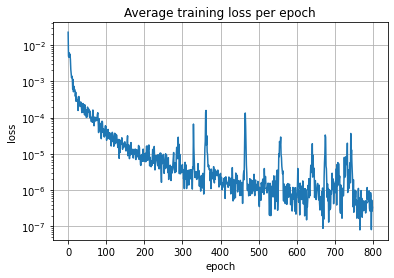

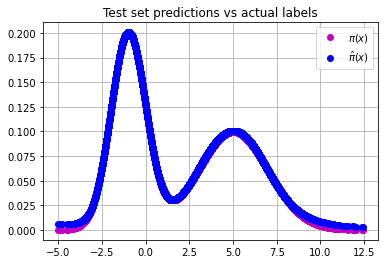

71 0.010209633827732168
71 8.19306686420259e-06
Finished Training
113.73695802688599


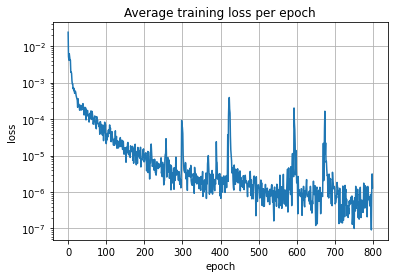

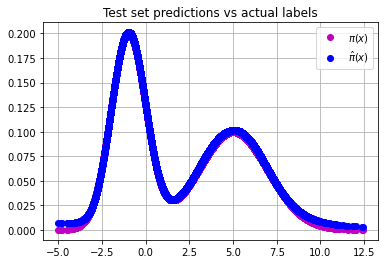

72 0.011473999682914175
72 1.1882726719465652e-05
Finished Training
111.13835263252258


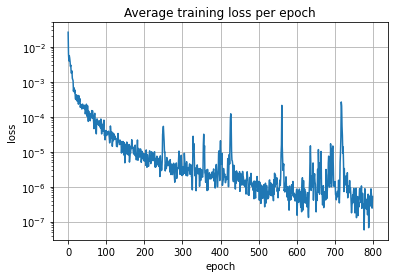

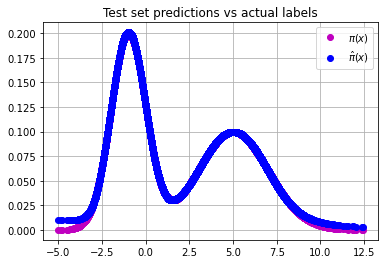

73 0.014213274683024989
73 9.185423067057975e-06
Finished Training
111.45611929893494


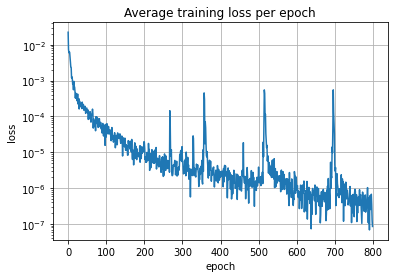

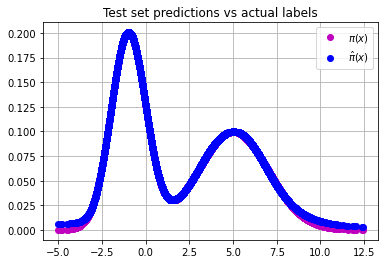

74 0.011509088545375622
74 8.211518200805245e-06
Finished Training
164.7436661720276


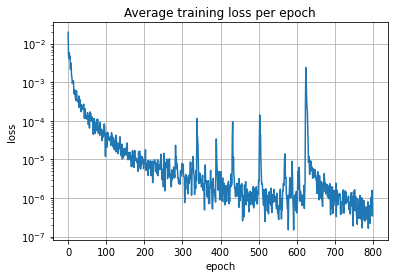

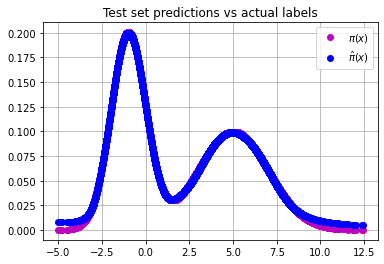

75 0.015943941079930916
75 1.1069140052582943e-05
Finished Training
114.40374088287354


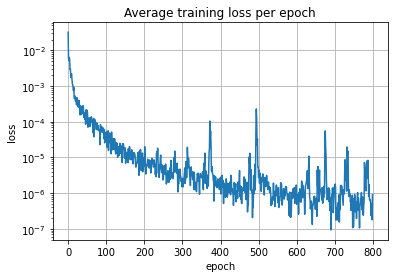

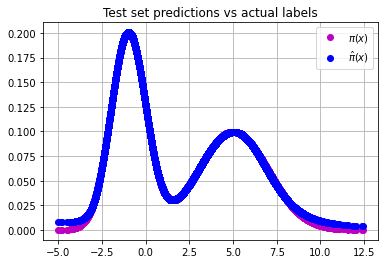

76 0.014352777918137695
76 1.0021503354100184e-05
Finished Training
112.84070301055908


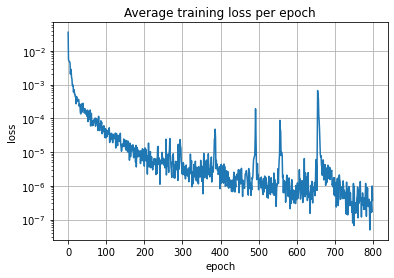

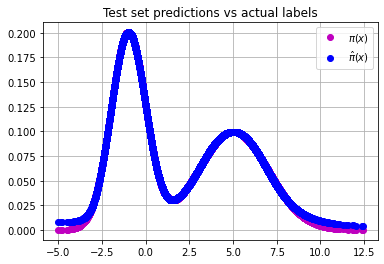

77 0.014948075068294441
77 1.1362381533774579e-05
Finished Training
111.88362336158752


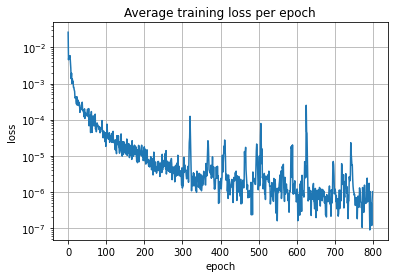

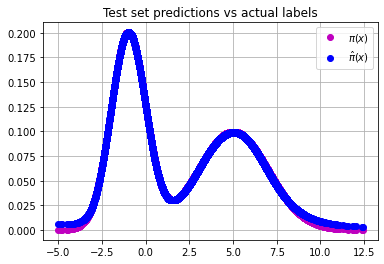

78 0.010770209396141723
78 6.227956438824234e-06
Finished Training
113.79964542388916


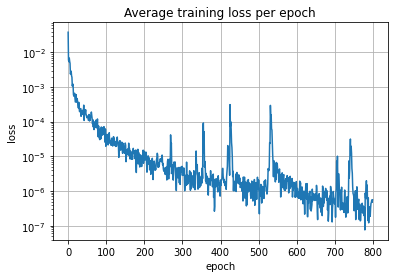

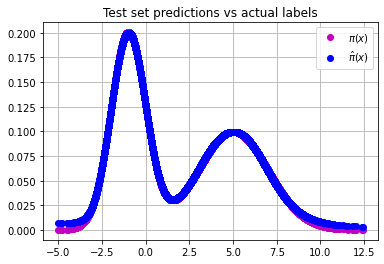

79 0.011700068271374856
79 8.11641395969007e-06
Finished Training
112.18189120292664


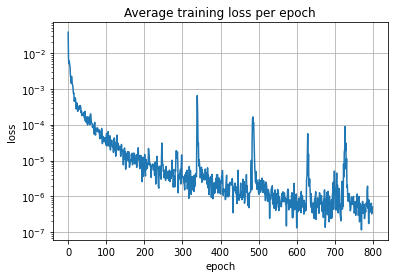

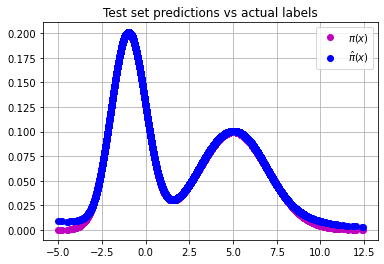

80 0.01408972235993918
80 1.2056951794518007e-05
Finished Training
113.07502722740173


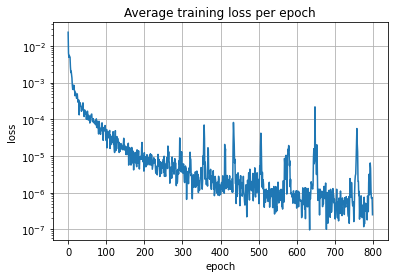

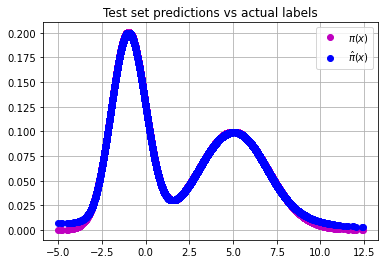

81 0.011592548292630895
81 7.933137346677006e-06
Finished Training
113.52845740318298


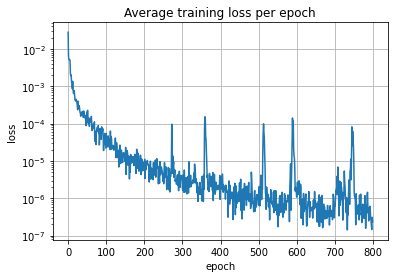

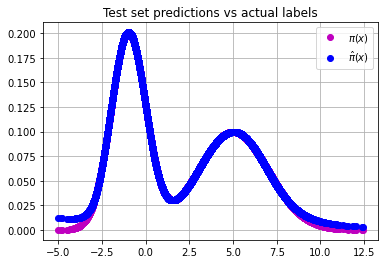

82 0.017446812762178604
82 1.329758490938374e-05
Finished Training
163.5456347465515


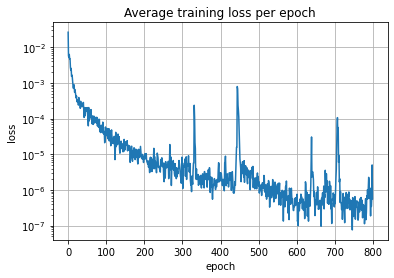

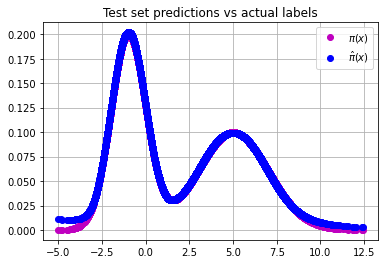

83 0.01461667864410105
83 8.641785935476858e-06
Finished Training
111.98776412010193


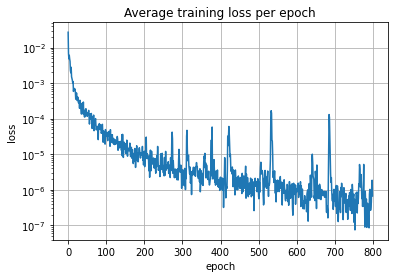

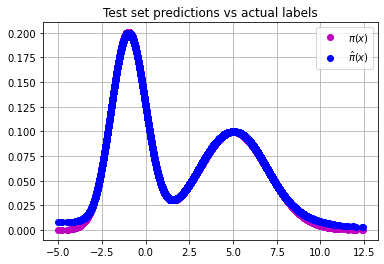

84 0.01277893209891076
84 1.1195334174319176e-05
Finished Training
112.4294662475586


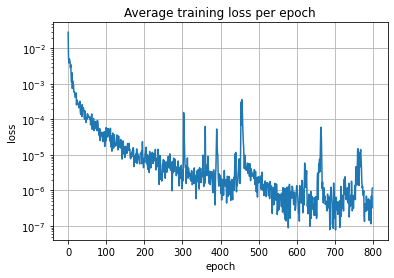

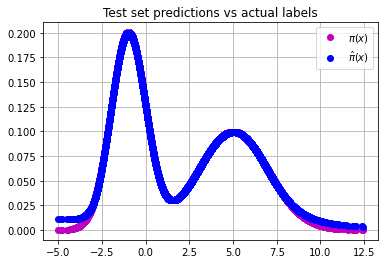

85 0.017293825523793094
85 1.4077013752902645e-05
Finished Training
110.67994356155396


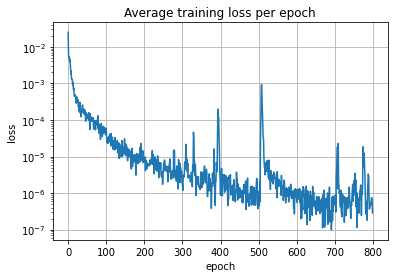

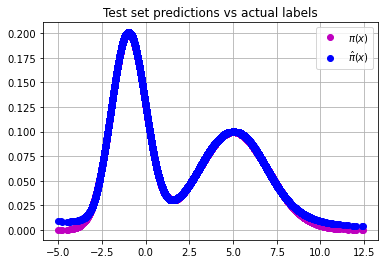

86 0.014448277651776902
86 1.1259461991163053e-05
Finished Training
163.50484251976013


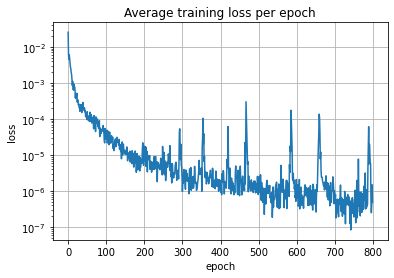

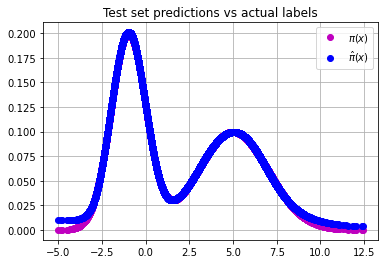

87 0.01611701194296524
87 1.217805530599323e-05
Finished Training
111.71571254730225


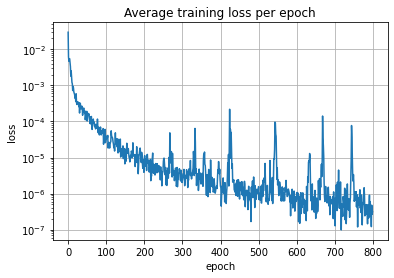

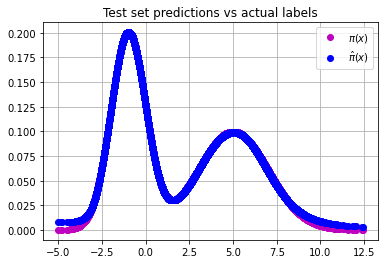

88 0.013408311710844256
88 8.614837018747279e-06
Finished Training
111.47296977043152


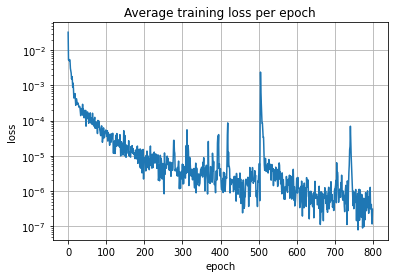

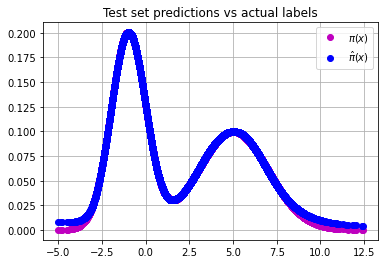

89 0.015230132394030335
89 1.34058862408899e-05
Finished Training
112.50169897079468


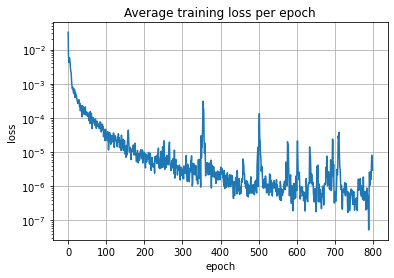

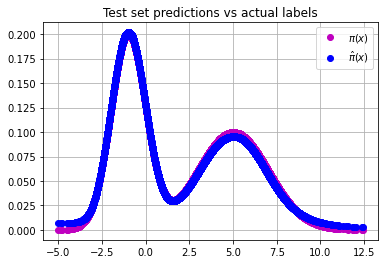

90 0.010972854229688765
90 5.8670269853275644e-06
Finished Training
164.19723534584045


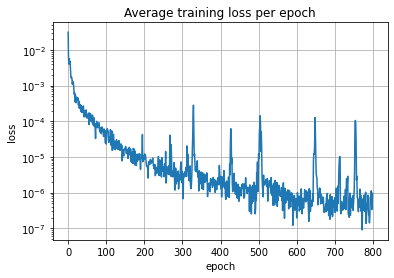

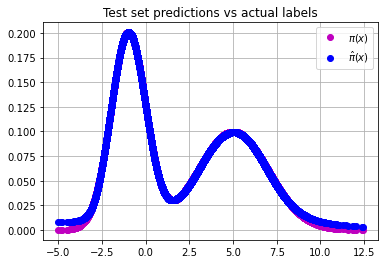

91 0.013558798732331909
91 8.098622695808964e-06
Finished Training
113.96166753768921


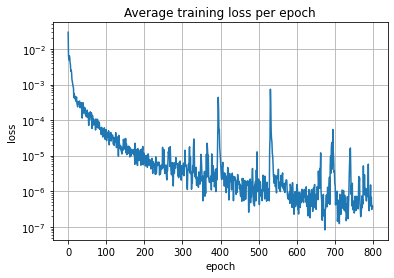

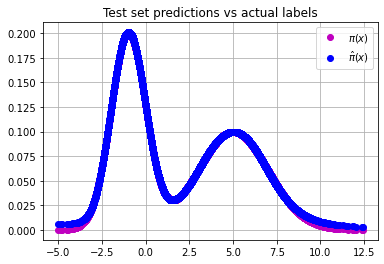

92 0.010638360631165536
92 6.651134814352102e-06
Finished Training
112.68686103820801


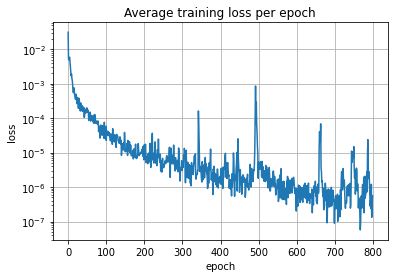

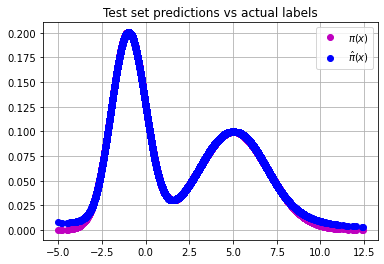

93 0.012918206312379976
93 9.978527548824903e-06
Finished Training
114.04558420181274


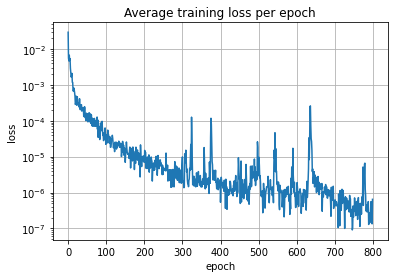

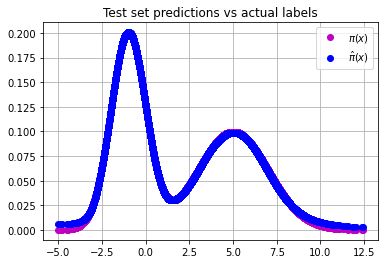

94 0.01000686758016671
94 4.5527038902541005e-06
Finished Training
163.22114443778992


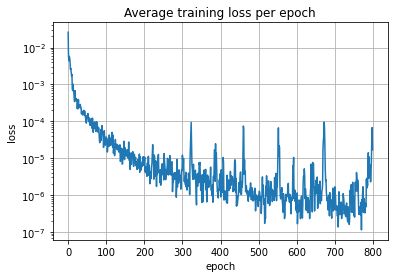

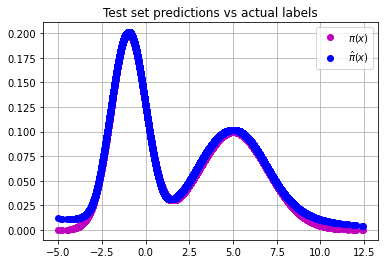

95 0.020548013991375152
95 3.580340275603823e-05
Finished Training
111.7698392868042


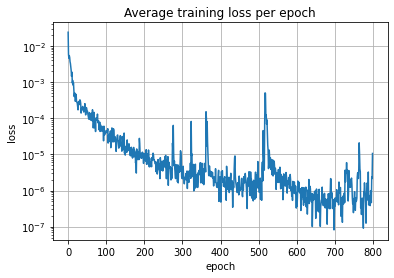

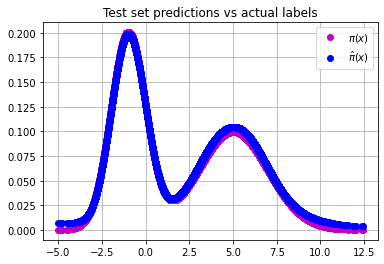

96 0.013472212109022363
96 3.379233965207734e-05
Finished Training
111.35373854637146


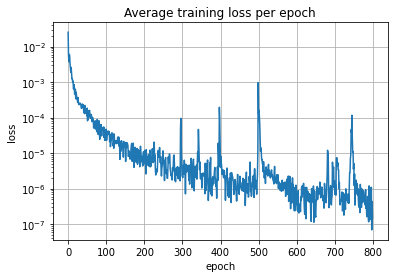

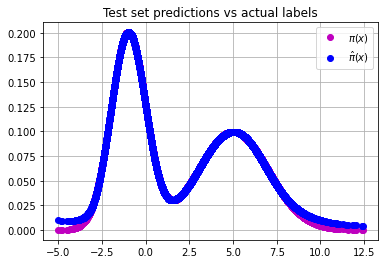

97 0.01721752672362082
97 1.4289908859250761e-05
Finished Training
110.27739334106445


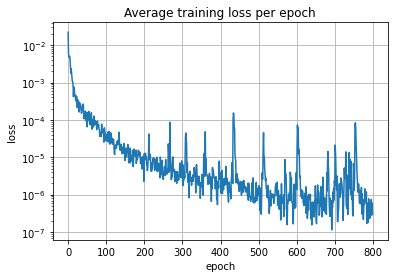

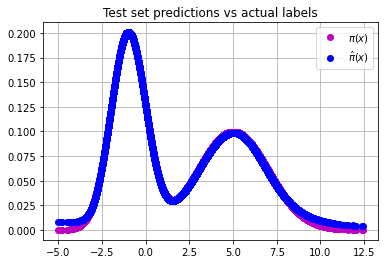

98 0.014745547186882191
98 8.693936834044634e-06
Finished Training
164.34314489364624


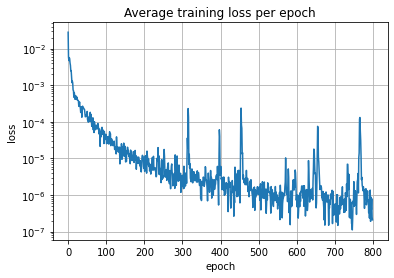

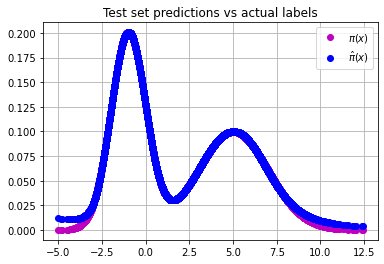

99 0.018222329036976192
99 1.5775466015022236e-05
Finished Training
112.84870934486389


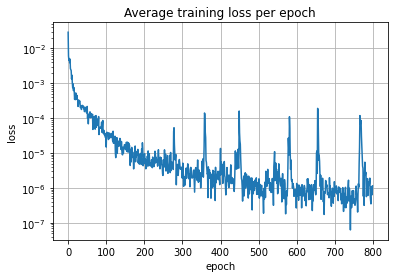

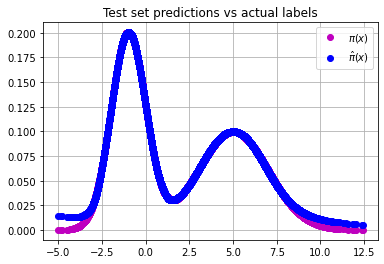

100 0.02459316437365633
100 2.4804301847516642e-05
Finished Training
113.11369943618774


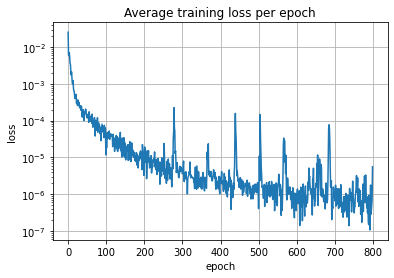

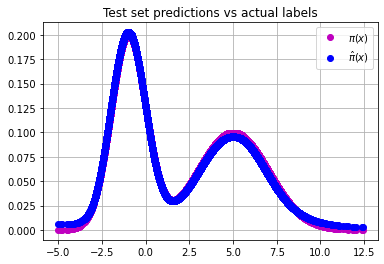

101 0.00992043073680075
101 6.460621001144617e-06
Finished Training
112.17905187606812


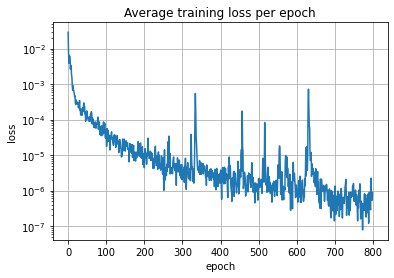

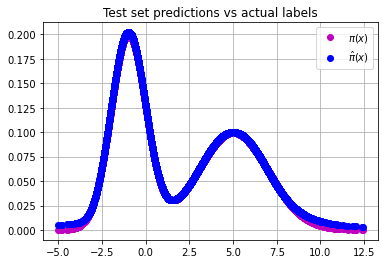

102 0.010771566045596164
102 6.535168441484321e-06
Finished Training
164.53947520256042


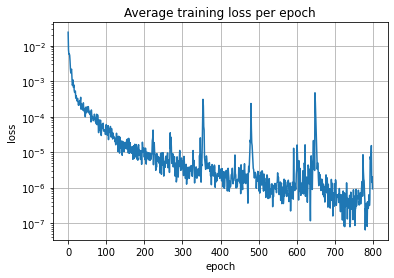

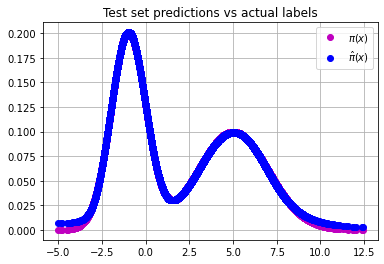

103 0.01157044128435001
103 6.146655765947037e-06
Finished Training
113.78914093971252


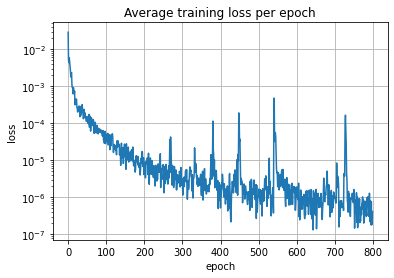

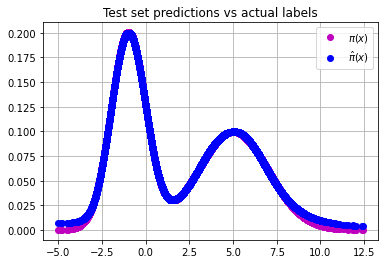

104 0.01418745171621224
104 1.2370878325927431e-05
Finished Training
112.97674584388733


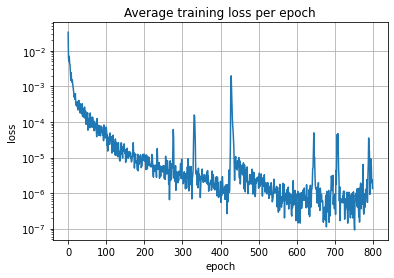

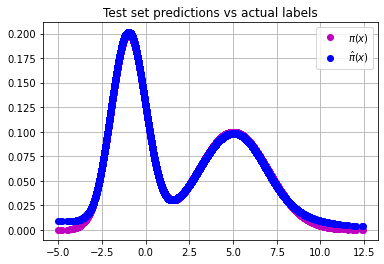

105 0.01585325179712563
105 9.83548677935584e-06
Finished Training
113.11152720451355


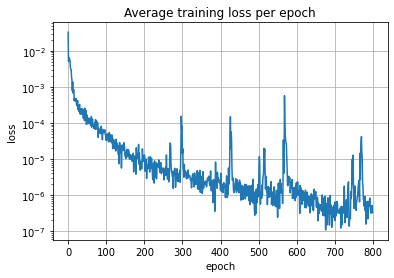

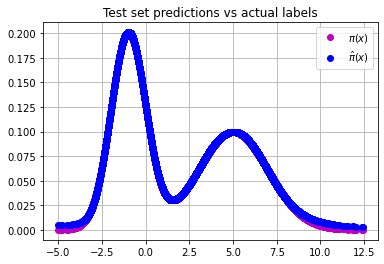

106 0.009419679779020827
106 5.502222696135019e-06
Finished Training
163.8417181968689


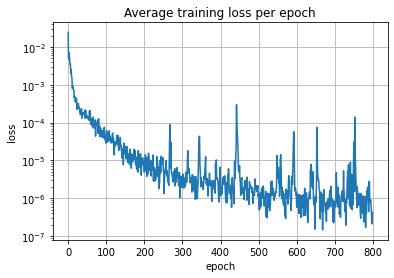

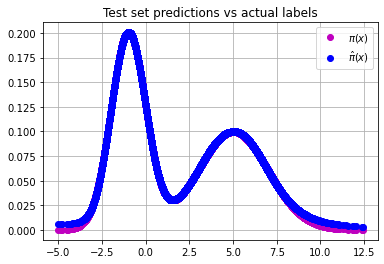

107 0.011704695992042064
107 9.229580402480548e-06
Finished Training
111.9308431148529


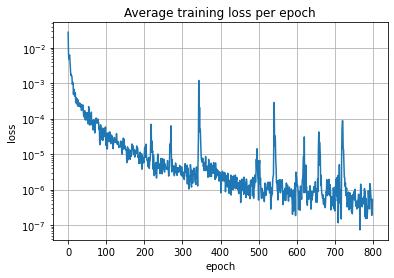

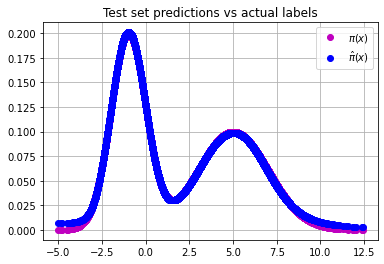

108 0.011260142039916848
108 5.283887183799994e-06
Finished Training
114.94329285621643


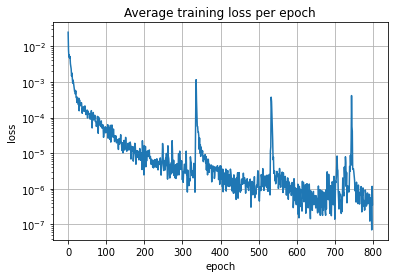

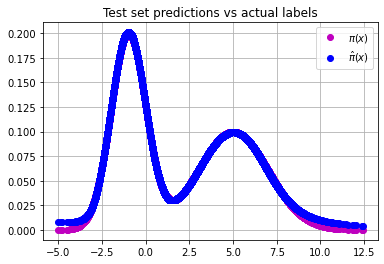

109 0.01605127817823156
109 1.1714217915736166e-05
Finished Training
111.33860158920288


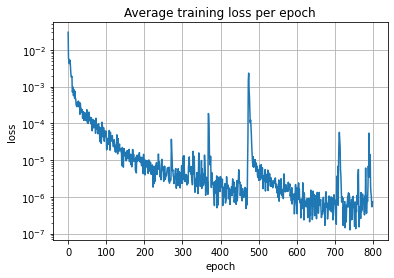

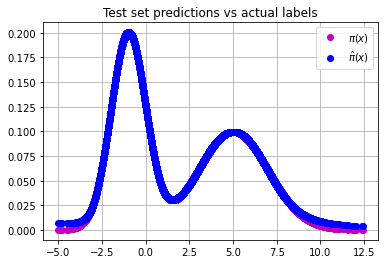

110 0.012386323217368583
110 8.21664524476755e-06
Finished Training
164.68668270111084


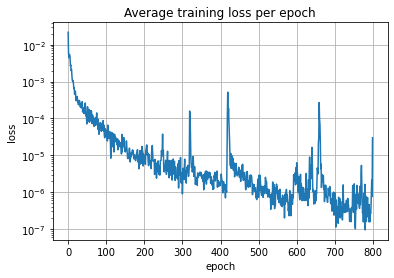

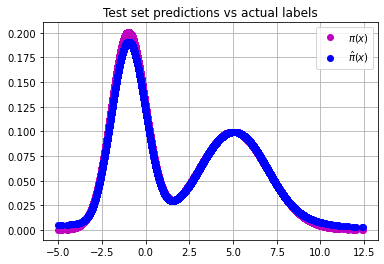

111 0.009429028315012723
111 2.1016227269731646e-05
Finished Training
113.91718697547913


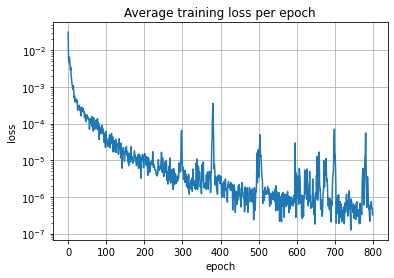

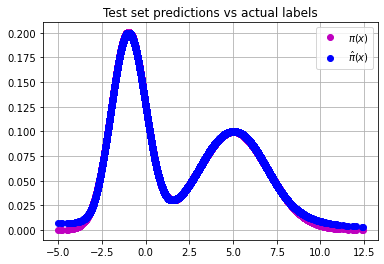

112 0.012262462847364514
112 9.741723739207762e-06
Finished Training
113.00087833404541


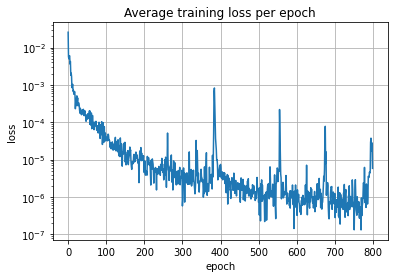

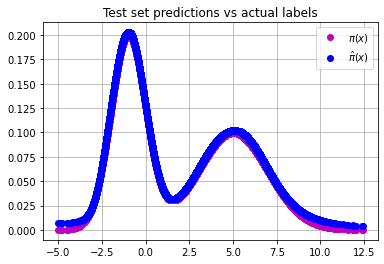

113 0.014209252294125787
113 1.773554651022542e-05
Finished Training
111.10473132133484


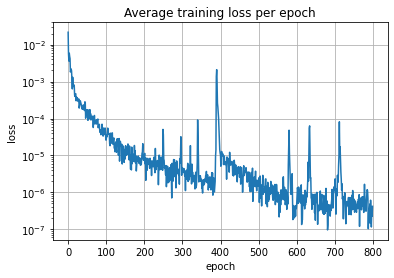

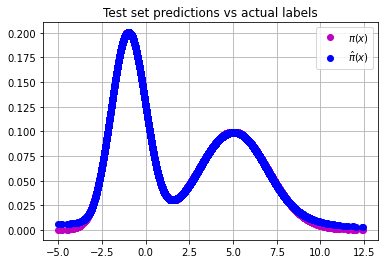

114 0.010508072533753072
114 5.534670178276282e-06
Finished Training
164.50225830078125


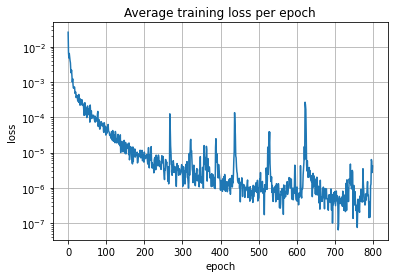

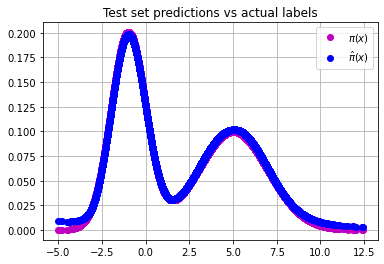

115 0.012922968953723975
115 1.97818216702648e-05
Finished Training
113.14502763748169


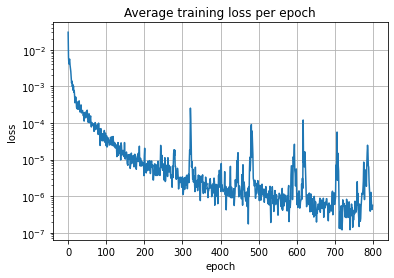

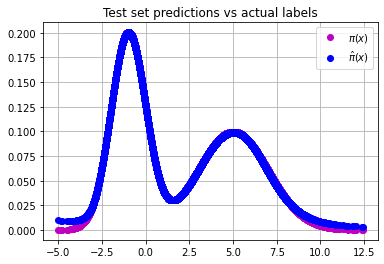

116 0.014111968894890345
116 8.680433519339633e-06
Finished Training
112.26501131057739


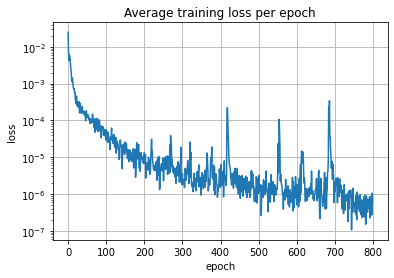

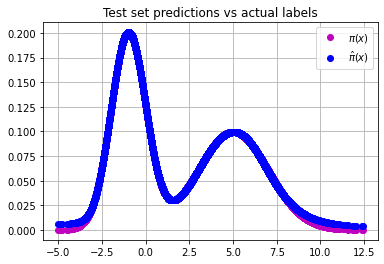

117 0.012385574334488125
117 8.733074969950962e-06
Finished Training
113.13363242149353


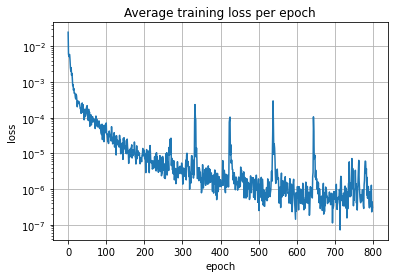

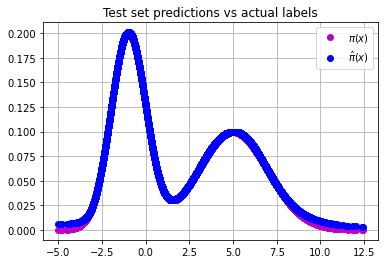

118 0.011602448291567223
118 8.63127581279532e-06
Finished Training
162.68791961669922


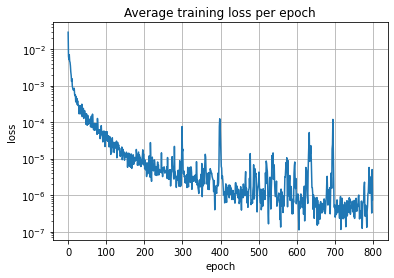

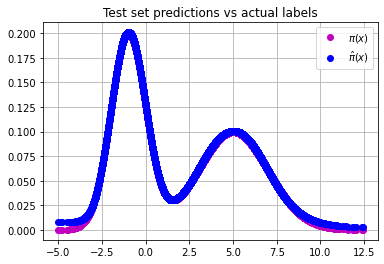

119 0.01093597873957017
119 7.770150494807034e-06
Finished Training
114.58924007415771


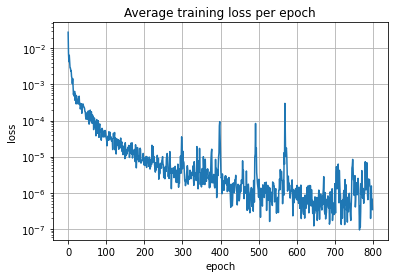

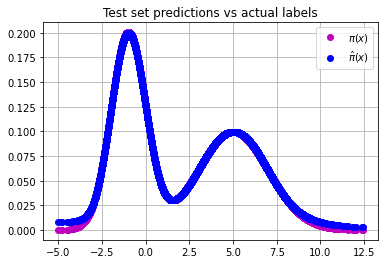

120 0.01245486774917341
120 9.290589334902e-06
Finished Training
112.38794040679932


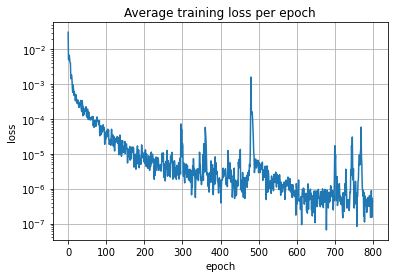

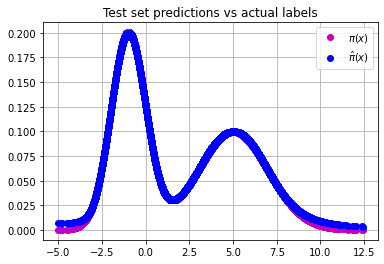

121 0.012705405028935824
121 1.0360585905681488e-05
Finished Training
112.82935571670532


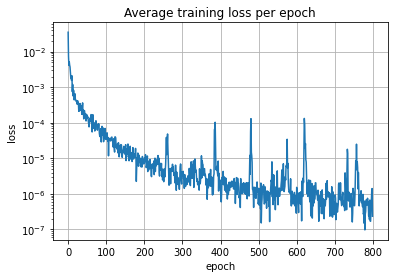

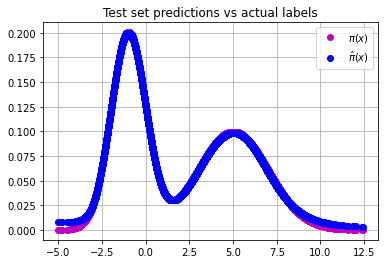

122 0.013002844307667473
122 7.5565665615966084e-06
Finished Training
163.34942483901978


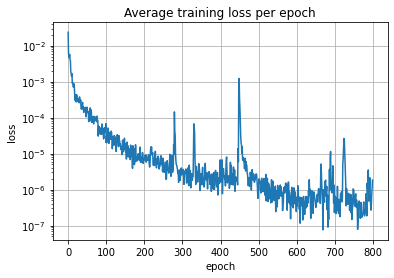

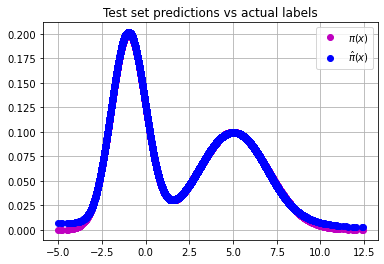

123 0.009916958366693339
123 4.431845305409221e-06
Finished Training
113.03394412994385


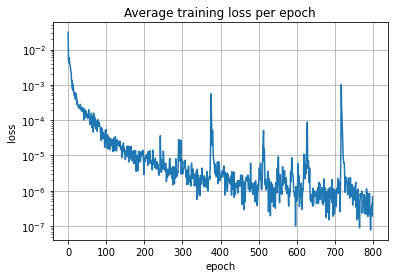

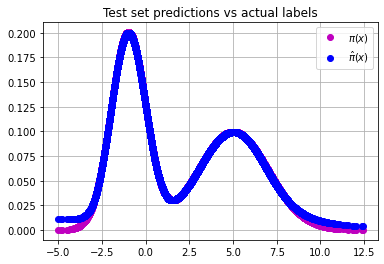

124 0.018051526210257025
124 1.4544281031050497e-05
Finished Training
112.93836951255798


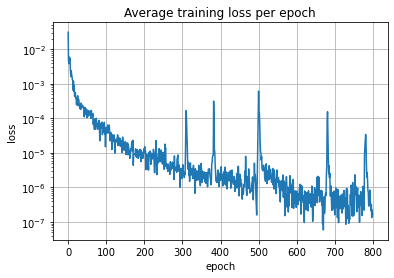

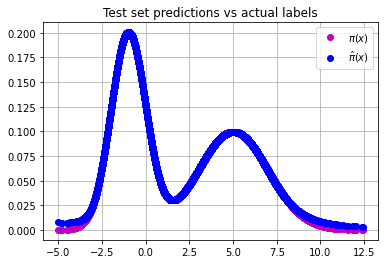

125 0.012656748756981242
125 8.203653175208586e-06
Finished Training
113.87780690193176


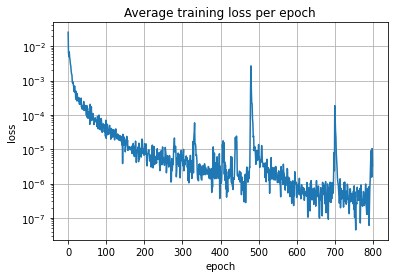

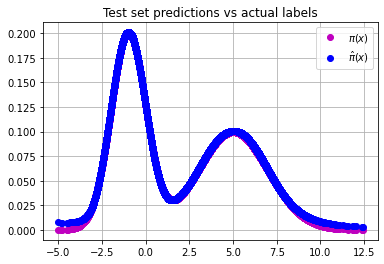

126 0.012370424810255829
126 1.0605534636056827e-05
Finished Training
163.67408418655396


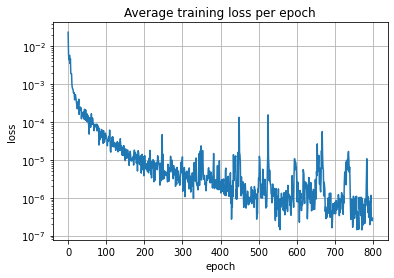

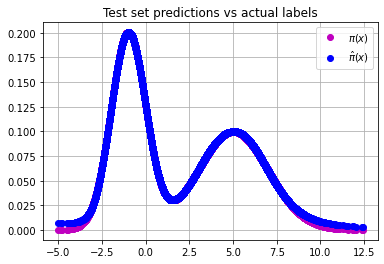

127 0.011778960205371064
127 8.772966450078591e-06
Finished Training
113.93783807754517


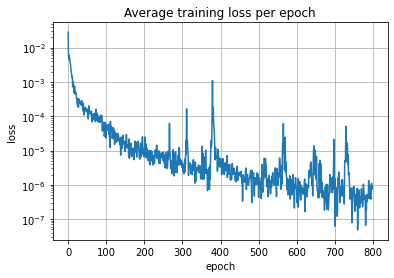

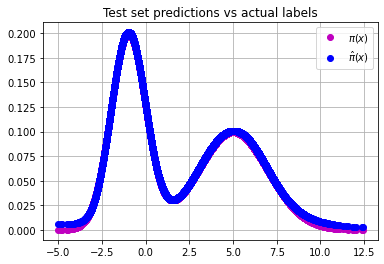

128 0.01005764482853295
128 8.895805228104713e-06
Finished Training
112.21506404876709


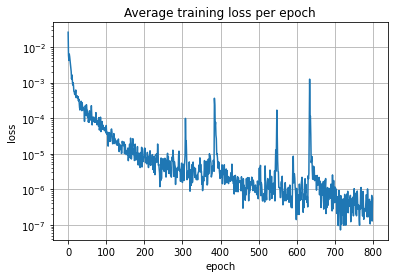

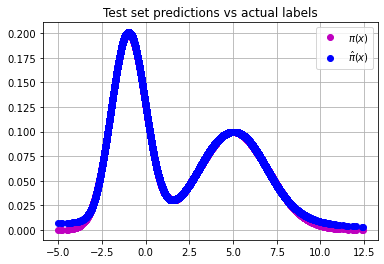

129 0.012000082622328921
129 8.094748218324875e-06
Finished Training
112.52226495742798


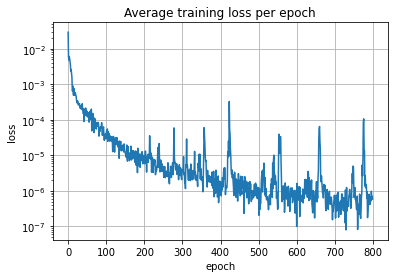

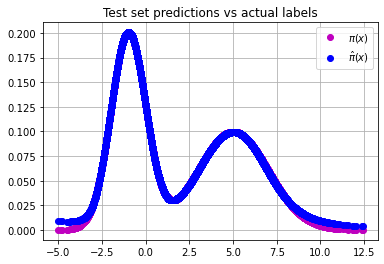

130 0.015222084401350406
130 1.0583024147957785e-05
Finished Training
163.44389724731445


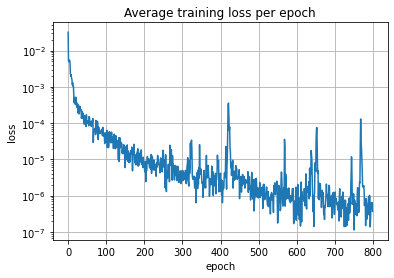

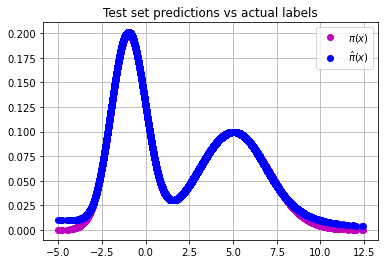

131 0.01744781405735779
131 1.3813891679555118e-05
Finished Training
111.74611973762512


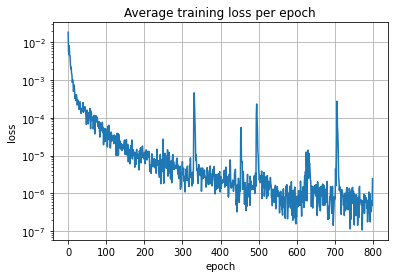

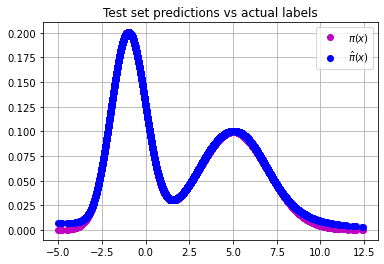

132 0.012343917281556415
132 1.1475612106769797e-05
Finished Training
111.60936212539673


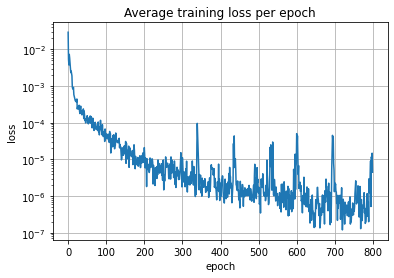

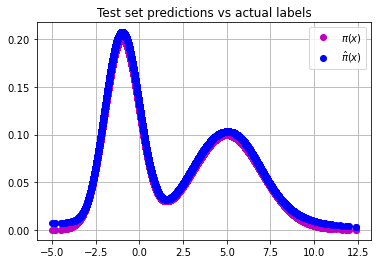

133 0.012871633373382898
133 1.3077640774451222e-05
Finished Training
112.16428780555725


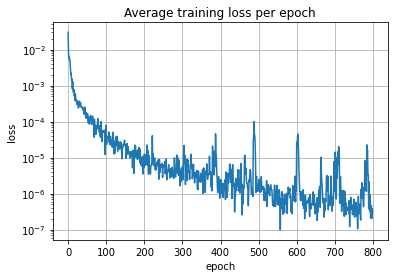

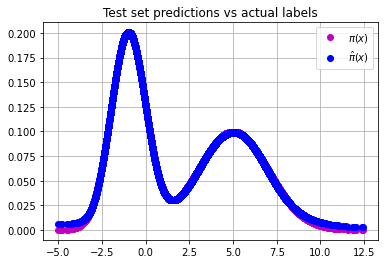

134 0.009380195162936924
134 4.424516476921978e-06
Finished Training
164.55954217910767


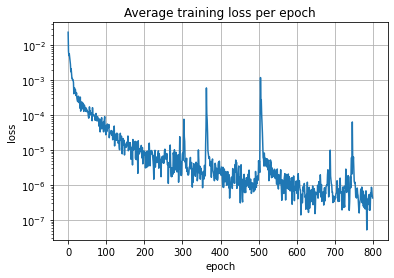

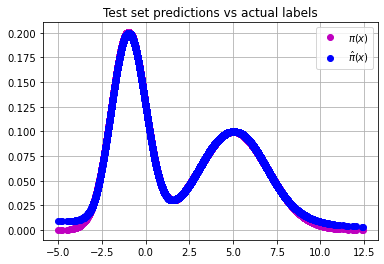

135 0.013979226651389174
135 1.157741585799693e-05
Finished Training
112.9733817577362


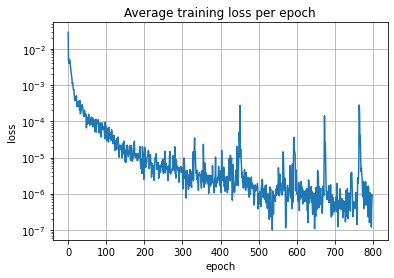

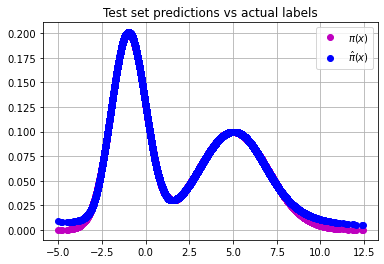

136 0.017932939335400862
136 1.5296568938242754e-05
Finished Training
113.41112279891968


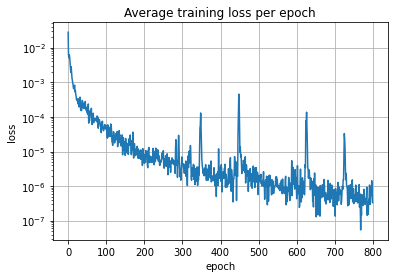

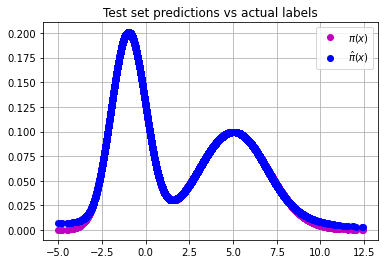

137 0.011799766196003569
137 7.083378235411507e-06
Finished Training
112.55201411247253


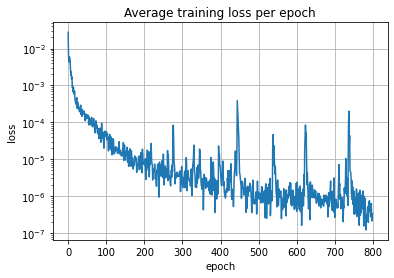

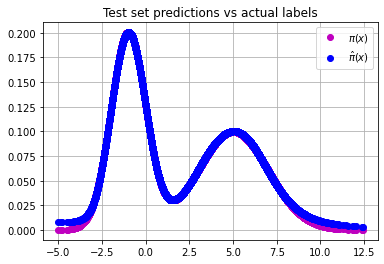

138 0.014192321880176047
138 1.2282100099061901e-05
Finished Training
165.54281044006348


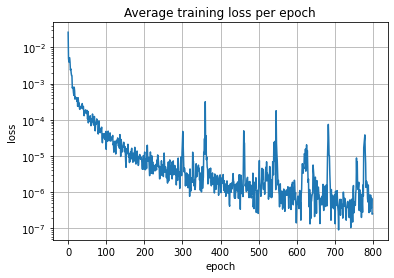

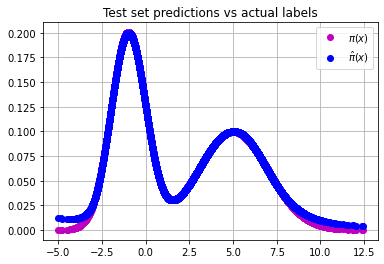

139 0.019146345864390433
139 1.8733069936610958e-05
Finished Training
112.27817821502686


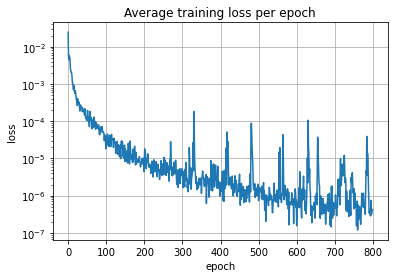

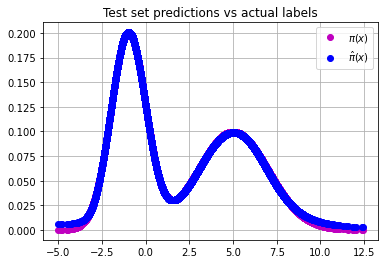

140 0.010102401234880896
140 4.8897879074656865e-06
Finished Training
111.77537631988525


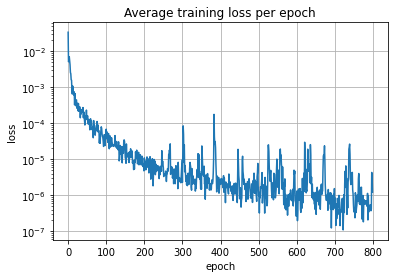

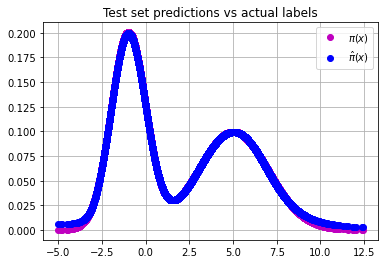

141 0.01003134675332045
141 6.9021515907174705e-06
Finished Training
112.21353244781494


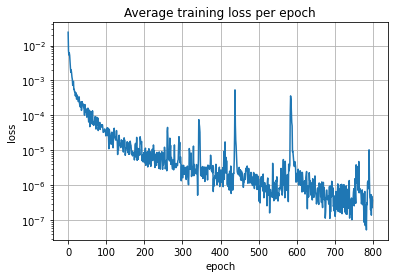

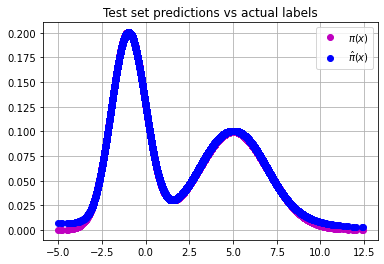

142 0.010465321806109412
142 9.07761385773681e-06
Finished Training
165.48180651664734


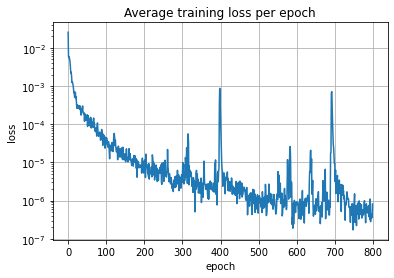

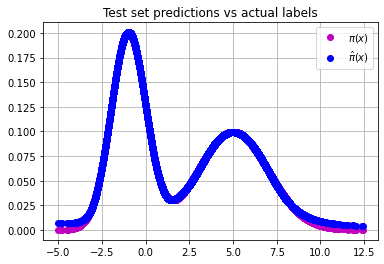

143 0.01300798369881006
143 8.141668178638196e-06
Finished Training
109.13557505607605


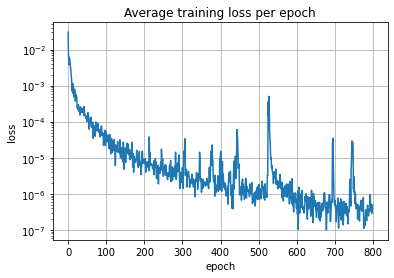

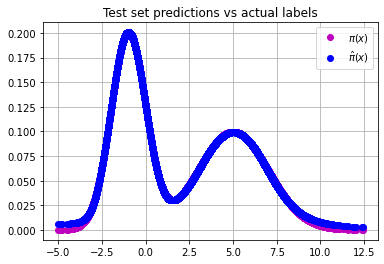

144 0.010255139958693532
144 5.2531551546499e-06
Finished Training
112.32521438598633


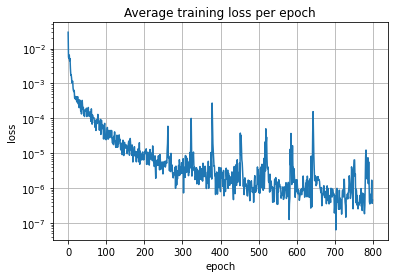

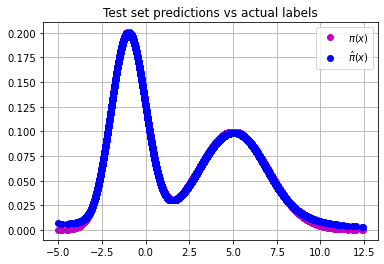

145 0.011654532905856555
145 6.4469200323027235e-06
Finished Training
113.51106691360474


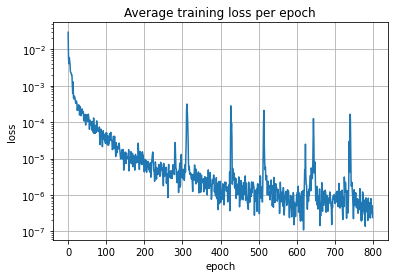

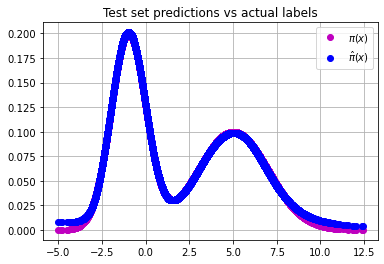

146 0.014706936387819315
146 9.370859828805266e-06
Finished Training
164.28020310401917


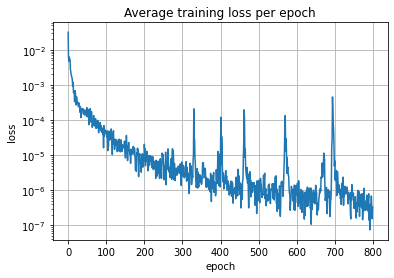

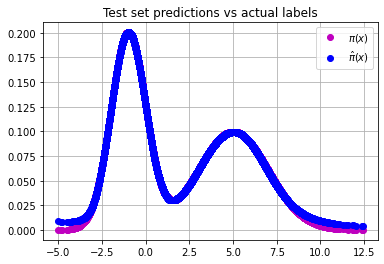

147 0.015344708649490746
147 1.0849818658482937e-05
Finished Training
114.77760338783264


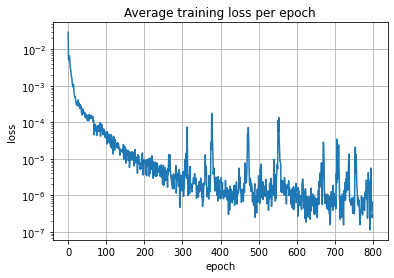

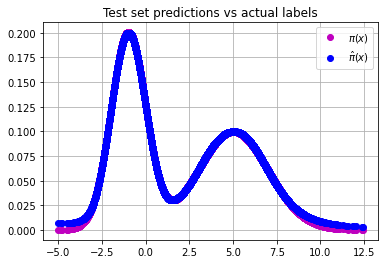

148 0.012303698105940486
148 9.889317475402327e-06
Finished Training
111.64327335357666


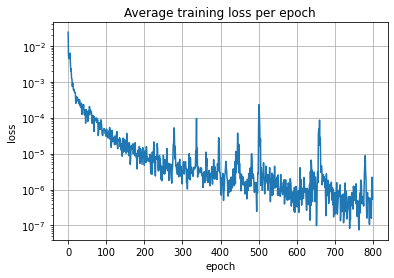

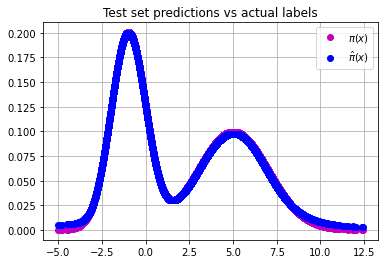

149 0.009918824914670069
149 4.111516856436951e-06


In [233]:
niters = 150
kl_div = np.zeros(niters)
mse    = np.zeros(niters)

for i in range(niters):
    data       = generate_data()
    data_set   = data[0]; labels = data[1]
    dataloader = data[2]
    t = time.time()
    dat = training(dataloader)
    elapsed = time.time() - t
    print(elapsed)
    losss = dat[0]; nepochs = dat[1]; net = dat[2];
    plot_loss(nepochs, losss,i)
    prediction = plot_prediction(test_set,test_labels,net,i)
    Z     =   normalisation_const(net)
    prediction = prediction / Z
#    pred = np.copy(prediction)

#     for k in range(len(prediction)):
#         if prediction[k] == 0:
# #            print('zero prediction')
#             prediction[k] = 10**(-20) 

    kl_div[i] = kl_divergence(V,prediction)
    mse[i]    = mean_sq_error(V,prediction)
    print(i,kl_div[i])
    print(i,mse[i])

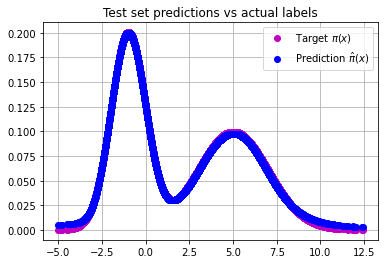

In [234]:
prediction = np.zeros(np.shape(test_labels)[0])
for j in range(np.shape(test_set)[0]):
    prediction[j] = net(test_set[j])#[0]
prediction = np.reshape(prediction,(len(prediction),1))
    
plt.plot(test_set,test_labels, 'om',label = 'Target $\pi(x)$')
plt.plot(test_set,prediction, 'o', color='blue', label = 'Prediction $\hat{\pi}(x)$')
plt.grid()
#    plt.ticklabel_format(axis="y", style="plain")
plt.title('Test set predictions vs actual labels')
plt.legend()
#plt.show()
plt.savefig('pred_vs_lab'.format(i))

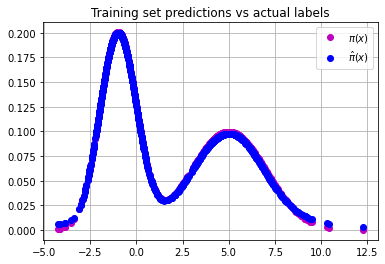

In [235]:
prediction = np.zeros(np.shape(labels)[0])
for j in range(np.shape(data_set)[0]):
    prediction[j] = net(torch.FloatTensor(data_set[j]))#[0]
prediction = np.reshape(prediction,(len(prediction),1))
    
plt.plot(data_set,labels, 'om',label = '$\pi(x)$')
plt.plot(data_set,prediction, 'o', color='blue', label = '$\hat{\pi}(x)$')
plt.grid()
#    plt.ticklabel_format(axis="y", style="plain")
plt.title('Training set predictions vs actual labels')
plt.legend()
plt.show()
#plt.savefig('pred_vs_lab{0}'.format(i))

In [236]:
print(np.sum(kl_div)/len(kl_div))

0.01352369462452927


In [126]:
# kl_div15 = kl_div
# mse_15 = mse

In [237]:
# kl_div30 = np.hstack((kl_div30,kl_div))
# mse_30 = np.hstack((mse_30,mse))

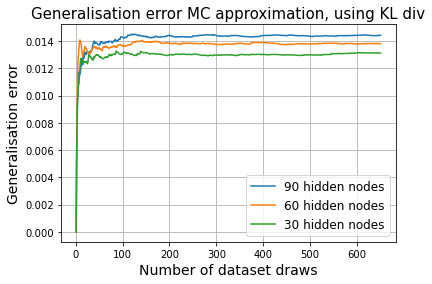

In [238]:
# ge120 = np.zeros(len(kl_div120))
# ge100 = np.zeros(len(kl_div100))
ge90 = np.zeros(len(kl_div90))
ge60 = np.zeros(len(kl_div60))
ge30 = np.zeros(len(kl_div30))
#ge15 = np.zeros(len(kl_div15))
# ge20 = np.zeros(len(kl_div20))
#ge5 = np.zeros(len(kl_div5))
for i in range(len(kl_div90)):
#     ge120[i] = sum(kl_div120[:i])/(i+1)
#     ge100[i] = sum(kl_div100[:i])/(i+1)
    ge90[i] = sum(kl_div90[:i])/(i+1)
    ge60[i] = sum(kl_div60[:i])/(i+1)
    ge30[i] = sum(kl_div30[:i])/(i+1)
#    ge15[i] = sum(kl_div15[:i])/(i+1)
#    ge5[i] = sum(kl_div5[:i])/(i+1)
#     ge20[i] = sum(kl_div20[:i])/(i+1)
#     ge4[i] = sum(kl_div4[:i])/(i+1)
    
i = np.linspace(1,len(kl_div90),len(kl_div90))
# plt.plot(i,ge120,label = '120 hidden nodes')#,color='b')
# plt.plot(i,ge100,label = '100 hidden nodes')#,color='orange')
plt.plot(i,ge90,label = '90 hidden nodes')#,color='g')
plt.plot(i,ge60,label = '60 hidden nodes')#,color='g')
plt.plot(i,ge30,label = '30 hidden nodes')#,color='g')
#plt.plot(i,ge15,label = '15 hidden nodes')#,color='g')
#plt.plot(i,ge5,label = '5 hidden nodes')#,color='g')
# plt.plot(i,ge20,label = '20 hidden nodes')#,color='g')
# plt.plot(i,ge4,label = '4 hidden nodes')#,color='g')
plt.grid()
plt.xlabel('Number of dataset draws',fontsize = 14)
plt.ylabel('Generalisation error',fontsize = 14)
plt.title('Generalisation error MC approximation, using KL div',fontsize = 15)
plt.legend(fontsize = 12)
plt.savefig('Generalization_error_Monte_Carlo_approximation_30_60_90_continuousKLdiv')


In [239]:
#kl_div5 = np.hstack((kl_div_5,kl_div))

In [240]:
# # cont_ge120 = np.zeros(len(cont_kl_div120))
# # cont_ge100 = np.zeros(len(cont_kl_div100))
# cont_ge30 = np.zeros(len(cont_kl_div30))
# # cont_ge20 = np.zeros(len(cont_kl_div20))
# # cont_ge4 = np.zeros(len(cont_kl_div4))
# for i in range(len(cont_kl_div30)):
# #     cont_ge120[i] = sum(cont_kl_div120[:i])/(i+1)
# #     cont_ge100[i] = sum(cont_kl_div100[:i])/(i+1)
#      cont_ge30[i] = sum(cont_kl_div30[:i])/(i+1)
# #     cont_ge20[i] = sum(cont_kl_div20[:i])/(i+1)
# #     cont_ge4[i] = sum(cont_kl_div4[:i])/(i+1)
    
# i = np.linspace(1,len(cont_kl_div30),len(cont_kl_div30))
# # plt.plot(i,cont_ge120,label = '120 hidden nodes')#,color='b')
# # plt.plot(i,cont_ge100,label = '100 hidden nodes')#,color='orange')
# plt.plot(i,cont_ge30,label = '30 hidden nodes')#,color='g')
# # plt.plot(i,cont_ge20,label = '20 hidden nodes')#,color='g')
# # plt.plot(i,cont_ge4,label = '4 hidden nodes')#,color='g')
# plt.grid()
# plt.xlabel('Number of dataset draws',fontsize = 14)
# plt.ylabel('Generalisation error',fontsize = 14)
# plt.title('Generalisation error Monte Carlo approximation',fontsize = 15)
# plt.legend(fontsize = 12)
# plt.savefig('cont_Generalization_error_Monte_Carlo_approximation_30_60_90_continuousKL1')


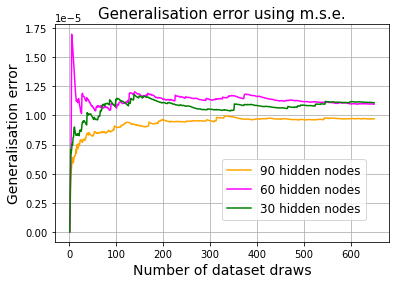

In [241]:
# mse_ge120 = np.zeros(len(mse_120))
# mse_ge100 = np.zeros(len(mse_100))
mse_ge90 = np.zeros(len(mse_90))
mse_ge60 = np.zeros(len(mse_60))
mse_ge30 = np.zeros(len(mse_30))
# mse_ge20 = np.zeros(len(mse_20))
# mse_ge4 = np.zeros(len(mse_4))
for i in range(len(mse_90)):
#     mse_ge120[i] = sum(mse_120[:i])/(i+1)
#     mse_ge100[i] = sum(mse_100[:i])/(i+1)
    mse_ge90[i] = sum(mse_90[:i])/(i+1)
    mse_ge60[i] = sum(mse_60[:i])/(i+1)
    mse_ge30[i] = sum(mse_30[:i])/(i+1)

#     mse_ge20[i] = sum(mse_20[:i])/(i+1)
#     mse_ge4[i] = sum(mse_4[:i])/(i+1)
    
i = np.linspace(1,len(mse_90),len(mse_90))
# plt.plot(i,mse_ge120,label = '120 hidden nodes')#,color='b')
# plt.plot(i,mse_ge100,label = '100 hidden nodes',color='blue')
plt.plot(i,mse_ge90,label = '90 hidden nodes',color='orange')
plt.plot(i,mse_ge60,label = '60 hidden nodes',color='magenta')
plt.plot(i,mse_ge30,label = '30 hidden nodes',color='green')
# plt.plot(i,mse_ge20,label = '20 hidden nodes',color='green')
# plt.plot(i,mse_ge4,label = '4 hidden nodes',color='orange')
plt.grid()
plt.xlabel('Number of dataset draws',fontsize = 14)
plt.ylabel('Generalisation error',fontsize = 14)
plt.title('Generalisation error using m.s.e.',fontsize = 15)
plt.legend(fontsize = 12,loc=(0.5,0.1))
plt.savefig('mse_generalization_error_Monte_Carlo_approximation_30_60_90')
